구글 드라이브를 이용한 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/dataset_directory.zip ./

Mounted at /content/drive


In [2]:
!unzip dataset_directory

Archive:  dataset_directory.zip
   creating: dataset_directory/
  inflating: dataset_directory/.DS_Store  
  inflating: __MACOSX/dataset_directory/._.DS_Store  
  inflating: dataset_directory/Andong_Fruit.csv  
  inflating: __MACOSX/dataset_directory/._Andong_Fruit.csv  
  inflating: dataset_directory/Climate_Chuncheon.csv  
  inflating: __MACOSX/dataset_directory/._Climate_Chuncheon.csv  
  inflating: dataset_directory/Andong_Grain.csv  
  inflating: __MACOSX/dataset_directory/._Andong_Grain.csv  
  inflating: dataset_directory/Climate_Jeju.csv  
  inflating: __MACOSX/dataset_directory/._Climate_Jeju.csv  
  inflating: dataset_directory/Jeju_Fruit.csv  
  inflating: __MACOSX/dataset_directory/._Jeju_Fruit.csv  
  inflating: dataset_directory/Chuncheon_Fruit.csv  
  inflating: __MACOSX/dataset_directory/._Chuncheon_Fruit.csv  
  inflating: dataset_directory/Chuncheon_Grain.csv  
  inflating: __MACOSX/dataset_directory/._Chuncheon_Grain.csv  
  inflating: dataset_directory/Jeju_Grain.cs

라이브러리 호출

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

데이터 로드

In [4]:
path_data = "dataset_directory"
climate_andong = pd.read_csv(path_data+"/Climate_Andong.csv")
climate_andong = climate_andong.iloc[:,1:]
climate_chuncheon = pd.read_csv(path_data+"/Climate_Chuncheon.csv")
climate_chuncheon = climate_chuncheon.iloc[:,1:]
climate_jeju = pd.read_csv(path_data+"/Climate_Jeju.csv")
climate_jeju = climate_jeju.iloc[:,1:]

데이터 결측치 보간(스플라인)

In [5]:
climate_chuncheon.interpolate(method='spline', inplace=True, order=1)
climate_andong.interpolate(method='spline', inplace=True, order=1)
climate_jeju.interpolate(method='spline', inplace=True, order=1)

넘파이 배열화 및 스케일링 (전처리)

In [6]:
climate_chuncheon_np = climate_chuncheon.to_numpy()
climate_andong_np = climate_andong.to_numpy()
climate_jeju_np = climate_jeju.to_numpy()

climate_np = np.array([climate_chuncheon_np, climate_andong_np, climate_jeju_np])

GPU Setting

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

True
cuda:0


기후 데이터 넘파이 배열에 적재

In [8]:
climate = list()
for j in range(3) : # 0 chuncheon 1 andong 2 jeju
    s = 0
    climate_year = list()
    for i in range(10) :
        climate_year.append(climate_np[j, s:s+365, :])
        if i != 1 and 5 and 9 :
            s += 365
        else :
            s += 366
    climate_year = np.stack(climate_year, 0)
    climate.append(climate_year)
climate = np.stack(climate, 0)
climate.shape

(3, 10, 365, 14)

훈련 데이터 셋 / 테스트 데이터 셋 분류

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

x_ss = StandardScaler()

dataset_list = []

for i in range(3) :
    cc = climate[i] # (10, 365, 14)
    dataset_list_pos = []
    for j in range(14) :
        x_cc = np.delete(cc, j, axis=2).reshape(-1, 13)
        y_cc = cc[:,:,j]
        x_scaled = x_ss.fit_transform(x_cc)
        x_scaled = x_scaled.reshape(10, 365, 13)
        x_cc_train = torch.FloatTensor(x_scaled[:9, :,:])
        x_cc_test = torch.FloatTensor(x_scaled[9, :, :])
        y_cc_train = torch.FloatTensor(y_cc[:9, :])
        y_cc_test = torch.FloatTensor(y_cc[9, :])
        train_dataset = TensorDataset(x_cc_train, y_cc_train)
        train_loader = DataLoader(train_dataset, batch_size=365, shuffle=False)
        test_dataset = TensorDataset(x_cc_test, y_cc_test)
        test_loader = DataLoader(test_dataset, batch_size=365, shuffle=False)
        dataset = (train_loader, test_loader)
        dataset_list_pos.append(dataset)
    dataset_list.append(dataset_list_pos)

기후 데이터 예측 LSTM 모델

In [10]:
class Climate_LSTM(nn.Module):
    def __init__(self, input_dim, seq_len, n_layers, hidden_dim, output_dim, device):
        super(Climate_LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim,
                            num_layers=self.n_layers,
                            batch_first=True)
        self.out = nn.Linear(self.hidden_dim, self.output_dim, bias=True)

    def forward(self, x): # 365*13
        h_0 = self._init_state()
        x, _ = self.lstm(x, h_0) # 365 * 100 
        h_t = x[:, -1] # 1 * 100
        logit = self.out(h_t)
        return logit

    def _init_state(self):
        new_cell_state = torch.zeros(self.n_layers, self.seq_len, self.hidden_dim).to(self.device)
        new_hidden_state = torch.zeros(self.n_layers, self.seq_len, self.hidden_dim).to(self.device)
        self.hidden = (new_hidden_state, new_cell_state)

훈련 및 평가 함수

In [11]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    running_loss = 0
    for i, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
      
        optimizer.zero_grad()
        logit = model(x)
        loss = criterion(logit, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        train_loss = running_loss / len(data_loader.dataset)
      
    return train_loss

def evaluate(model, criterion, data_loader):
    model.eval()
    running_loss = 0
    
    for i, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        
        logit = model(torch.unsqueeze(x, 0))
        predicted = torch.flatten(logit)
        loss = criterion(logit, y)
        running_loss += loss.item() * x.size(0)
        test_loss = running_loss / len(data_loader.dataset)
        
    return test_loss, predicted

def evaluate2(model, criterion, data_loader):
    model.eval()
    running_loss = 0
    
    for i, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        
        logit = model(x)
        predicted = torch.flatten(logit)
        loss = criterion(logit, y)
        running_loss += loss.item() * x.size(0)
        test_loss = running_loss / len(data_loader.dataset)
        
    return test_loss, predicted

LSTM 모델 파라미터 세팅

In [12]:
n_layers = 1
hidden_dim = 100
seq_len = 365
input_dim = 13
output_dim = 365
num_epochs = 1000
early_stop_patience = 100

훈련 및 평가 함수

In [13]:
def train_and_eval(model, train_loader, test_loader, epoch, criterion, optimizer, early_stop_patience) :
  train_loss_list = []
  test_loss_list = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = None
  patience = 0

  for e in range(1, epoch+1):
      train_loss = train(model, criterion, optimizer, train_loader)
      test_loss, predicted = evaluate(model, criterion, test_loader)
      if e%10 == 0 :
          print("[Epoch: %d] train loss : %5.2f | test loss : %5.2f" % (e, train_loss, test_loss))
      train_loss_list.append(train_loss)
      test_loss_list.append(test_loss)
      if e == 1:
        best_loss = test_loss
      if test_loss <= best_loss :
        best_loss = test_loss
        patience = 0
        best_model_wts = copy.deepcopy(model.state_dict())
      else :
        patience += 1
      if (patience >= early_stop_patience) :     
              print('\nEarly Stopping')
              print(f'Epoch : {e}')
              break

  plt.subplot(1, 2, 1)
  plt.plot(np.arange(e), train_loss_list, label='train')
  plt.plot(np.arange(e), test_loss_list, label='test')
  plt.legend()
  plt.title("loss")

  for x, y in test_loader :
    y_test = y
  predicted = predicted.detach().cpu().numpy()
  
  predicted = predicted.reshape(-1,1)

  plt.subplot(1, 2, 2)
  plt.plot(np.arange(365), predicted, label = 'pred')
  plt.plot(np.arange(365), y_test, label = 'true')
  plt.legend()
  plt.title("predict")
  plt.show()
  return model

In [14]:
def train_again(model, criterion, optimizer, data_loader):
    model.train()
    running_loss = 0
    for i, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        
        model._init_state()
        optimizer.zero_grad()
        logit = model(torch.unsqueeze(x, 0))
        loss = criterion(logit, torch.unsqueeze(y,0))
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        train_loss = running_loss / len(data_loader.dataset)
    return model

feature list

In [15]:
pos_list = ["춘천", "안동", "제주"]
feature_list = list(climate_andong.columns)

모델 훈련 및 평가 진행 후 해당 모델로 기후 데이터 예측


춘천, 1.5M 평균 습도(%)



/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 10] train loss : 4089.15 | test loss : 4205.35
[Epoch: 20] train loss : 2975.45 | test loss : 3077.61
[Epoch: 30] train loss : 2059.17 | test loss : 2152.61
[Epoch: 40] train loss : 1377.25 | test loss : 1465.04
[Epoch: 50] train loss : 903.93 | test loss : 986.62
[Epoch: 60] train loss : 593.61 | test loss : 671.46
[Epoch: 70] train loss : 400.04 | test loss : 473.65
[Epoch: 80] train loss : 284.53 | test loss : 354.83
[Epoch: 90] train loss : 218.29 | test loss : 286.32
[Epoch: 100] train loss : 181.67 | test loss : 248.34
[Epoch: 110] train loss : 162.14 | test loss : 228.12
[Epoch: 120] train loss : 152.09 | test loss : 217.78
[Epoch: 130] train loss : 147.12 | test loss : 212.70
[Epoch: 140] train loss : 144.77 | test loss : 210.28
[Epoch: 150] train loss : 143.70 | test loss : 209.14
[Epoch: 160] train loss : 143.25 | test loss : 208.58
[Epoch: 170] train loss : 143.06 | test loss : 208.28
[Epoch: 180] train loss : 142.99 | test loss : 208.09
[Epoch: 190] train loss : 142

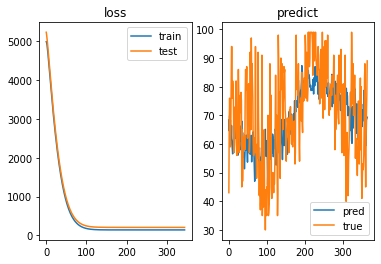

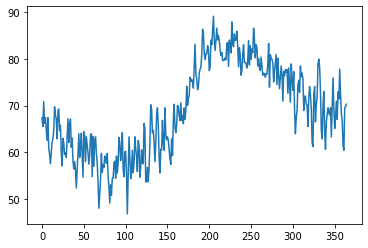


춘천, 10CM 일 토양수분(%)

[Epoch: 10] train loss : 136.32 | test loss : 61.88
[Epoch: 20] train loss : 52.78 | test loss : 70.16


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 55.15 | test loss : 101.93
[Epoch: 40] train loss : 51.11 | test loss : 83.23
[Epoch: 50] train loss : 49.42 | test loss : 68.30
[Epoch: 60] train loss : 49.29 | test loss : 68.82
[Epoch: 70] train loss : 49.04 | test loss : 72.82
[Epoch: 80] train loss : 49.01 | test loss : 73.54
[Epoch: 90] train loss : 48.98 | test loss : 72.13
[Epoch: 100] train loss : 48.98 | test loss : 71.92
[Epoch: 110] train loss : 48.97 | test loss : 72.32

Early Stopping
Epoch : 114


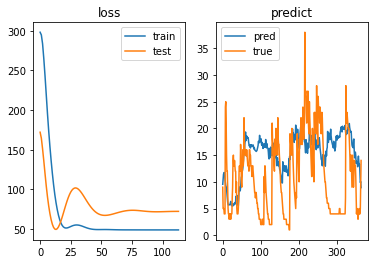

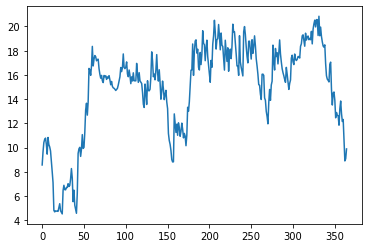


춘천, 20CM 일 토양수분(%)

[Epoch: 10] train loss : 194.18 | test loss : 19.03


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 20] train loss : 80.09 | test loss : 54.23
[Epoch: 30] train loss : 75.21 | test loss : 121.14
[Epoch: 40] train loss : 73.87 | test loss : 110.54
[Epoch: 50] train loss : 70.50 | test loss : 80.12
[Epoch: 60] train loss : 70.00 | test loss : 71.75
[Epoch: 70] train loss : 68.73 | test loss : 77.19
[Epoch: 80] train loss : 67.55 | test loss : 80.15
[Epoch: 90] train loss : 66.33 | test loss : 79.44
[Epoch: 100] train loss : 64.82 | test loss : 78.30
[Epoch: 110] train loss : 63.29 | test loss : 76.80

Early Stopping
Epoch : 112


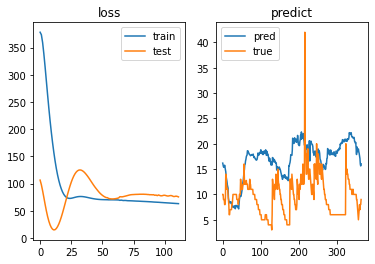

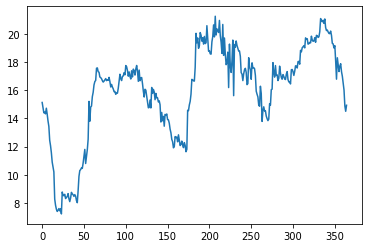


춘천, 30CM 일 토양수분(%)

[Epoch: 10] train loss : 110.38 | test loss : 22.10
[Epoch: 20] train loss : 76.05 | test loss : 117.70


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 76.17 | test loss : 117.00
[Epoch: 40] train loss : 73.44 | test loss : 83.19
[Epoch: 50] train loss : 73.05 | test loss : 81.51
[Epoch: 60] train loss : 72.26 | test loss : 87.75
[Epoch: 70] train loss : 72.73 | test loss : 89.17
[Epoch: 80] train loss : 72.63 | test loss : 87.09
[Epoch: 90] train loss : 72.52 | test loss : 87.28
[Epoch: 100] train loss : 72.41 | test loss : 87.72

Early Stopping
Epoch : 106


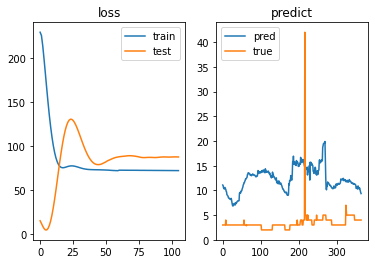

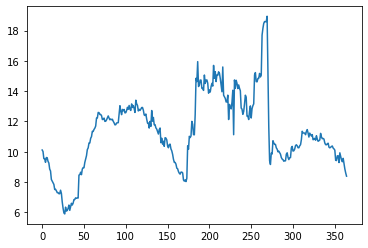


춘천, 50CM 일 토양수분(%)

[Epoch: 10] train loss : 431.22 | test loss : 17.56


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 20] train loss : 328.95 | test loss : 31.65
[Epoch: 30] train loss : 326.52 | test loss : 81.99
[Epoch: 40] train loss : 324.22 | test loss : 75.57
[Epoch: 50] train loss : 321.40 | test loss : 53.30
[Epoch: 60] train loss : 321.03 | test loss : 44.72
[Epoch: 70] train loss : 320.87 | test loss : 47.52
[Epoch: 80] train loss : 320.75 | test loss : 51.15
[Epoch: 90] train loss : 320.74 | test loss : 51.48
[Epoch: 100] train loss : 320.72 | test loss : 50.45
[Epoch: 110] train loss : 320.72 | test loss : 50.04

Early Stopping
Epoch : 114


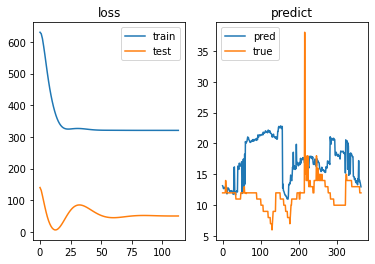

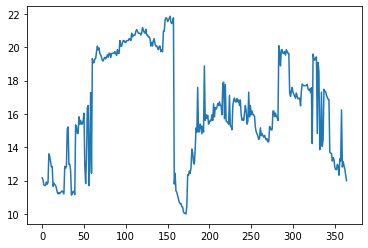


춘천, 1.5M 평균 기온(°C)

[Epoch: 10] train loss : 113.07 | test loss : 95.12
[Epoch: 20] train loss : 26.01 | test loss : 23.93


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 10.11 | test loss : 14.42
[Epoch: 40] train loss : 10.41 | test loss : 14.75
[Epoch: 50] train loss :  8.99 | test loss : 13.42
[Epoch: 60] train loss :  8.09 | test loss : 12.50
[Epoch: 70] train loss :  7.97 | test loss : 12.01
[Epoch: 80] train loss :  7.92 | test loss : 11.81
[Epoch: 90] train loss :  7.89 | test loss : 11.83
[Epoch: 100] train loss :  7.88 | test loss : 11.92
[Epoch: 110] train loss :  7.88 | test loss : 11.96
[Epoch: 120] train loss :  7.87 | test loss : 11.95
[Epoch: 130] train loss :  7.87 | test loss : 11.91
[Epoch: 140] train loss :  7.87 | test loss : 11.90
[Epoch: 150] train loss :  7.87 | test loss : 11.92
[Epoch: 160] train loss :  7.87 | test loss : 11.92
[Epoch: 170] train loss :  7.87 | test loss : 11.92
[Epoch: 180] train loss :  7.87 | test loss : 11.92

Early Stopping
Epoch : 182


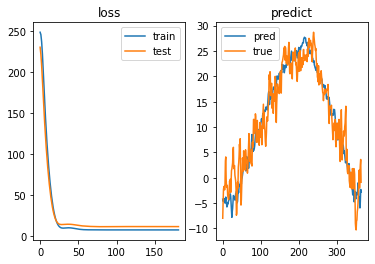

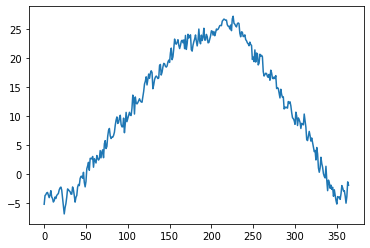


춘천, 평균 지면온도(°C)

[Epoch: 10] train loss : 176.85 | test loss : 143.17
[Epoch: 20] train loss : 51.29 | test loss : 39.21


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 13.50 | test loss : 12.82
[Epoch: 40] train loss : 10.70 | test loss : 13.17
[Epoch: 50] train loss : 10.68 | test loss : 13.04
[Epoch: 60] train loss :  9.34 | test loss : 11.20
[Epoch: 70] train loss :  8.85 | test loss : 10.26
[Epoch: 80] train loss :  8.83 | test loss :  9.98
[Epoch: 90] train loss :  8.79 | test loss : 10.00
[Epoch: 100] train loss :  8.77 | test loss : 10.09
[Epoch: 110] train loss :  8.77 | test loss : 10.11
[Epoch: 120] train loss :  8.77 | test loss : 10.11
[Epoch: 130] train loss :  8.77 | test loss : 10.11
[Epoch: 140] train loss :  8.77 | test loss : 10.10
[Epoch: 150] train loss :  8.77 | test loss : 10.09
[Epoch: 160] train loss :  8.77 | test loss : 10.09
[Epoch: 170] train loss :  8.77 | test loss : 10.10
[Epoch: 180] train loss :  8.77 | test loss : 10.10

Early Stopping
Epoch : 184


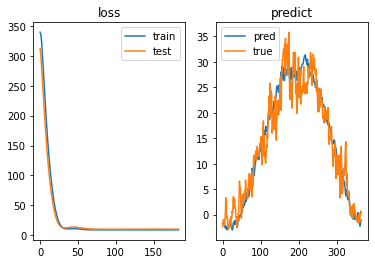

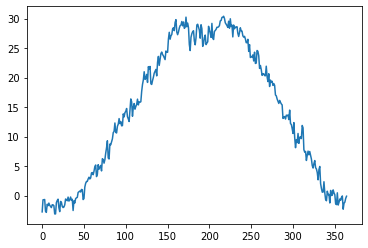


춘천, 5CM 평균 지중온도(°C)

[Epoch: 10] train loss : 159.94 | test loss : 123.86
[Epoch: 20] train loss : 41.75 | test loss : 28.03


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  9.34 | test loss :  7.79
[Epoch: 40] train loss :  7.66 | test loss :  9.38
[Epoch: 50] train loss :  7.27 | test loss :  8.75
[Epoch: 60] train loss :  5.98 | test loss :  6.80
[Epoch: 70] train loss :  5.62 | test loss :  5.86
[Epoch: 80] train loss :  5.60 | test loss :  5.58
[Epoch: 90] train loss :  5.56 | test loss :  5.63
[Epoch: 100] train loss :  5.54 | test loss :  5.73
[Epoch: 110] train loss :  5.54 | test loss :  5.77
[Epoch: 120] train loss :  5.54 | test loss :  5.77
[Epoch: 130] train loss :  5.54 | test loss :  5.76
[Epoch: 140] train loss :  5.54 | test loss :  5.74
[Epoch: 150] train loss :  5.54 | test loss :  5.74
[Epoch: 160] train loss :  5.54 | test loss :  5.74
[Epoch: 170] train loss :  5.54 | test loss :  5.75
[Epoch: 180] train loss :  5.54 | test loss :  5.75

Early Stopping
Epoch : 183


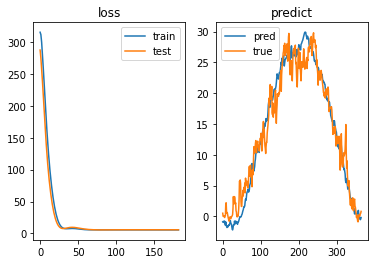

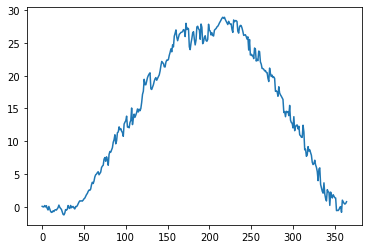


춘천, 30CM 평균 지중온도(°C)

[Epoch: 10] train loss : 142.51 | test loss : 107.66


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 20] train loss : 34.33 | test loss : 20.77
[Epoch: 30] train loss :  6.24 | test loss :  5.78
[Epoch: 40] train loss :  5.46 | test loss :  7.80
[Epoch: 50] train loss :  4.84 | test loss :  6.32
[Epoch: 60] train loss :  3.58 | test loss :  4.16
[Epoch: 70] train loss :  3.34 | test loss :  3.30
[Epoch: 80] train loss :  3.32 | test loss :  3.22
[Epoch: 90] train loss :  3.27 | test loss :  3.36
[Epoch: 100] train loss :  3.26 | test loss :  3.47
[Epoch: 110] train loss :  3.26 | test loss :  3.48
[Epoch: 120] train loss :  3.26 | test loss :  3.44
[Epoch: 130] train loss :  3.26 | test loss :  3.42
[Epoch: 140] train loss :  3.26 | test loss :  3.42
[Epoch: 150] train loss :  3.26 | test loss :  3.43
[Epoch: 160] train loss :  3.26 | test loss :  3.43
[Epoch: 170] train loss :  3.26 | test loss :  3.43

Early Stopping
Epoch : 177


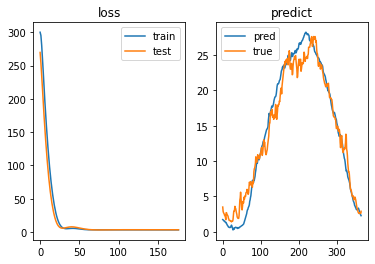

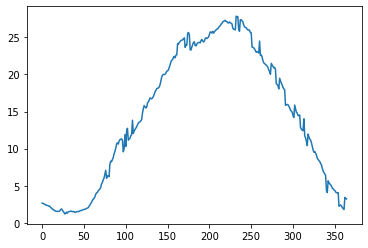


춘천, 0.5M 일 지중온도(°C)

[Epoch: 10] train loss : 129.06 | test loss : 95.60
[Epoch: 20] train loss : 27.20 | test loss : 15.69


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  6.07 | test loss :  5.97
[Epoch: 40] train loss :  6.18 | test loss :  7.46
[Epoch: 50] train loss :  5.07 | test loss :  5.23
[Epoch: 60] train loss :  3.86 | test loss :  3.27
[Epoch: 70] train loss :  3.69 | test loss :  2.63
[Epoch: 80] train loss :  3.65 | test loss :  2.60
[Epoch: 90] train loss :  3.60 | test loss :  2.74
[Epoch: 100] train loss :  3.59 | test loss :  2.82
[Epoch: 110] train loss :  3.59 | test loss :  2.82
[Epoch: 120] train loss :  3.59 | test loss :  2.79
[Epoch: 130] train loss :  3.59 | test loss :  2.77
[Epoch: 140] train loss :  3.59 | test loss :  2.77
[Epoch: 150] train loss :  3.59 | test loss :  2.78
[Epoch: 160] train loss :  3.59 | test loss :  2.78
[Epoch: 170] train loss :  3.59 | test loss :  2.78

Early Stopping
Epoch : 176


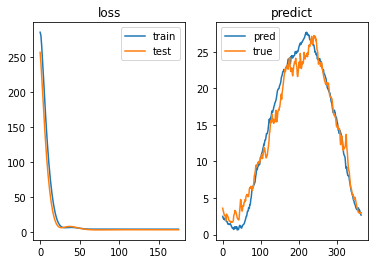

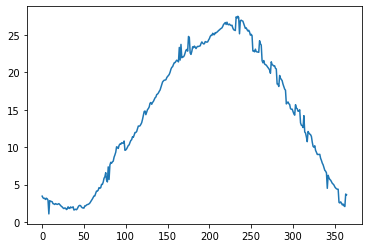


춘천, 1.0M 일 지중온도(°C)

[Epoch: 10] train loss : 105.34 | test loss : 80.91
[Epoch: 20] train loss : 18.60 | test loss : 11.45


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  4.96 | test loss :  5.47
[Epoch: 40] train loss :  5.53 | test loss :  6.24
[Epoch: 50] train loss :  3.82 | test loss :  3.67
[Epoch: 60] train loss :  2.93 | test loss :  2.32
[Epoch: 70] train loss :  2.89 | test loss :  2.11
[Epoch: 80] train loss :  2.82 | test loss :  2.13
[Epoch: 90] train loss :  2.79 | test loss :  2.25
[Epoch: 100] train loss :  2.78 | test loss :  2.27
[Epoch: 110] train loss :  2.78 | test loss :  2.23
[Epoch: 120] train loss :  2.78 | test loss :  2.20
[Epoch: 130] train loss :  2.78 | test loss :  2.21
[Epoch: 140] train loss :  2.77 | test loss :  2.22
[Epoch: 150] train loss :  2.75 | test loss :  2.21
[Epoch: 160] train loss :  2.71 | test loss :  2.21
[Epoch: 170] train loss :  2.65 | test loss :  2.21

Early Stopping
Epoch : 172


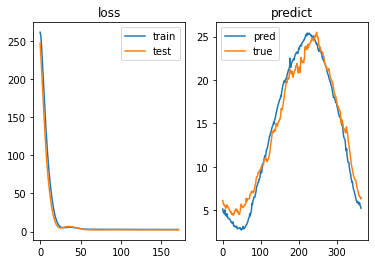

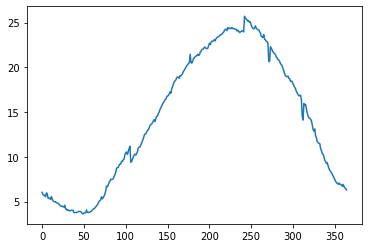


춘천, 일사량

[Epoch: 10] train loss : 89.83 | test loss : 82.21
[Epoch: 20] train loss : 30.15 | test loss : 36.05


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 28.86 | test loss : 38.18
[Epoch: 40] train loss : 26.47 | test loss : 35.35
[Epoch: 50] train loss : 25.34 | test loss : 33.61
[Epoch: 60] train loss : 25.08 | test loss : 33.30
[Epoch: 70] train loss : 24.97 | test loss : 33.45
[Epoch: 80] train loss : 24.92 | test loss : 33.33
[Epoch: 90] train loss : 24.91 | test loss : 33.29
[Epoch: 100] train loss : 24.90 | test loss : 33.32
[Epoch: 110] train loss : 24.88 | test loss : 33.33
[Epoch: 120] train loss : 24.78 | test loss : 33.27
[Epoch: 130] train loss : 24.58 | test loss : 33.19
[Epoch: 140] train loss : 24.34 | test loss : 33.17
[Epoch: 150] train loss : 24.08 | test loss : 33.12
[Epoch: 160] train loss : 23.84 | test loss : 33.08
[Epoch: 170] train loss : 23.62 | test loss : 33.06
[Epoch: 180] train loss : 23.41 | test loss : 33.04
[Epoch: 190] train loss : 23.22 | test loss : 33.02
[Epoch: 200] train loss : 23.05 | test loss : 33.01
[Epoch: 210] train loss : 22.90 | test loss : 33.00
[Epoch: 220] train 

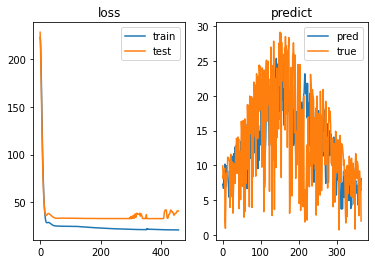

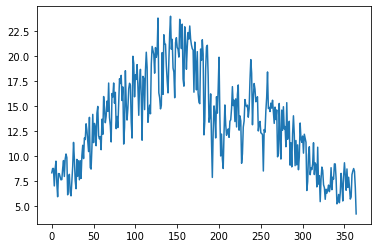


춘천, 일조시간

[Epoch: 10] train loss : 12.78 | test loss : 12.02
[Epoch: 20] train loss : 12.52 | test loss : 14.43


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 11.61 | test loss : 12.06
[Epoch: 40] train loss : 11.41 | test loss : 12.32
[Epoch: 50] train loss : 11.34 | test loss : 12.21
[Epoch: 60] train loss : 11.30 | test loss : 12.26
[Epoch: 70] train loss : 11.24 | test loss : 12.13
[Epoch: 80] train loss : 11.15 | test loss : 12.22
[Epoch: 90] train loss : 11.04 | test loss : 12.17
[Epoch: 100] train loss : 10.91 | test loss : 12.18

Early Stopping
Epoch : 109


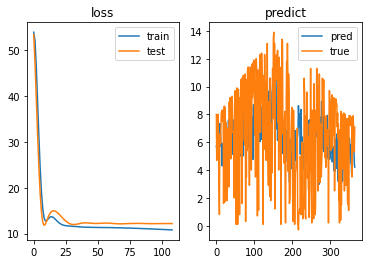

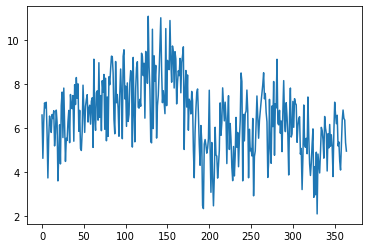


춘천, 최대풍속

[Epoch: 10] train loss :  5.66 | test loss :  6.46
[Epoch: 20] train loss :  5.70 | test loss :  7.13


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  5.02 | test loss :  4.34
[Epoch: 40] train loss :  4.76 | test loss :  5.27
[Epoch: 50] train loss :  4.67 | test loss :  4.90
[Epoch: 60] train loss :  4.63 | test loss :  4.92
[Epoch: 70] train loss :  4.60 | test loss :  4.88
[Epoch: 80] train loss :  4.57 | test loss :  4.91
[Epoch: 90] train loss :  4.54 | test loss :  4.89
[Epoch: 100] train loss :  4.49 | test loss :  4.89
[Epoch: 110] train loss :  4.44 | test loss :  4.92
[Epoch: 120] train loss :  4.38 | test loss :  4.89
[Epoch: 130] train loss :  4.32 | test loss :  4.92

Early Stopping
Epoch : 130


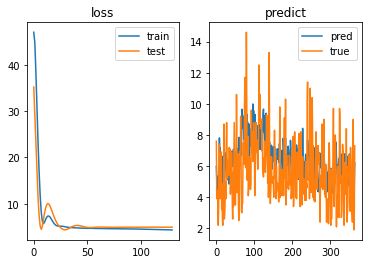

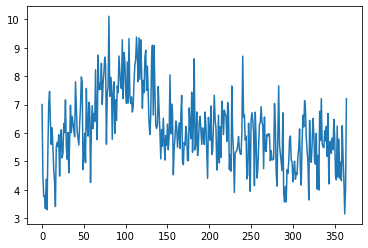


안동, 1.5M 평균 습도(%)

[Epoch: 10] train loss : 4235.15 | test loss : 4258.54
[Epoch: 20] train loss : 3107.61 | test loss : 3118.19


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 2183.56 | test loss : 2188.01
[Epoch: 40] train loss : 1487.32 | test loss : 1488.51
[Epoch: 50] train loss : 994.50 | test loss : 993.36
[Epoch: 60] train loss : 662.88 | test loss : 660.11
[Epoch: 70] train loss : 449.42 | test loss : 445.91
[Epoch: 80] train loss : 317.35 | test loss : 314.11
[Epoch: 90] train loss : 238.51 | test loss : 236.44
[Epoch: 100] train loss : 192.97 | test loss : 192.70
[Epoch: 110] train loss : 167.49 | test loss : 169.31
[Epoch: 120] train loss : 153.69 | test loss : 157.56
[Epoch: 130] train loss : 146.49 | test loss : 152.14
[Epoch: 140] train loss : 142.87 | test loss : 149.93
[Epoch: 150] train loss : 141.12 | test loss : 149.23
[Epoch: 160] train loss : 140.33 | test loss : 149.14
[Epoch: 170] train loss : 139.98 | test loss : 149.25
[Epoch: 180] train loss : 139.84 | test loss : 149.39
[Epoch: 190] train loss : 139.79 | test loss : 149.50
[Epoch: 200] train loss : 139.77 | test loss : 149.57
[Epoch: 210] train loss : 139.7

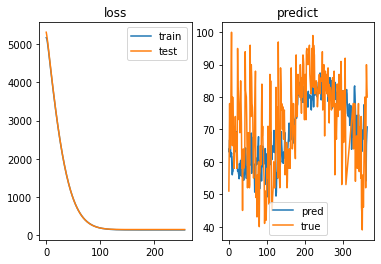

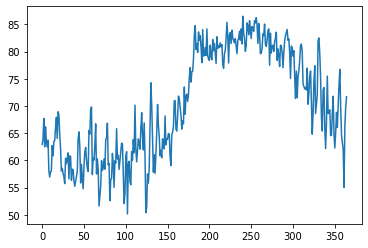


안동, 10CM 일 토양수분(%)

[Epoch: 10] train loss : 51.78 | test loss : 184.84
[Epoch: 20] train loss : 50.78 | test loss : 189.47


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 49.19 | test loss : 200.83
[Epoch: 40] train loss : 48.97 | test loss : 195.60
[Epoch: 50] train loss : 48.80 | test loss : 194.16
[Epoch: 60] train loss : 48.52 | test loss : 196.01
[Epoch: 70] train loss : 47.99 | test loss : 195.35
[Epoch: 80] train loss : 47.09 | test loss : 195.50
[Epoch: 90] train loss : 45.65 | test loss : 197.41
[Epoch: 100] train loss : 44.03 | test loss : 197.63
[Epoch: 110] train loss : 42.15 | test loss : 204.35

Early Stopping
Epoch : 113


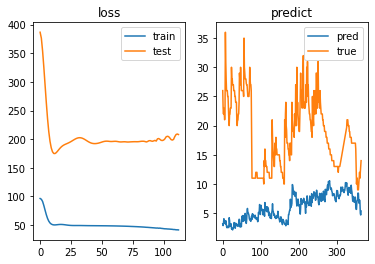

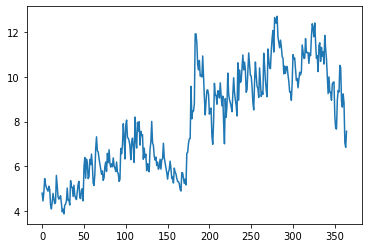


안동, 20CM 일 토양수분(%)

[Epoch: 10] train loss : 82.12 | test loss : 67.91
[Epoch: 20] train loss : 41.11 | test loss : 140.21


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 43.71 | test loss : 162.20
[Epoch: 40] train loss : 39.36 | test loss : 120.91
[Epoch: 50] train loss : 39.47 | test loss : 113.86
[Epoch: 60] train loss : 39.02 | test loss : 125.33
[Epoch: 70] train loss : 38.98 | test loss : 126.44
[Epoch: 80] train loss : 38.66 | test loss : 124.79
[Epoch: 90] train loss : 38.13 | test loss : 122.74
[Epoch: 100] train loss : 37.48 | test loss : 123.73
[Epoch: 110] train loss : 36.74 | test loss : 123.97

Early Stopping
Epoch : 110


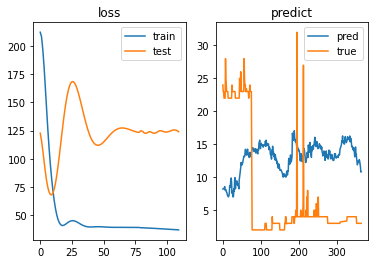

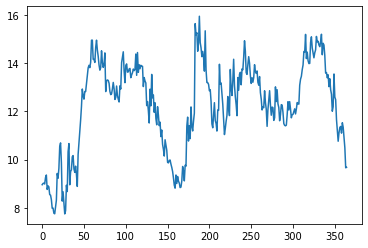


안동, 30CM 일 토양수분(%)

[Epoch: 10] train loss : 66.63 | test loss : 17.42
[Epoch: 20] train loss : 24.22 | test loss : 63.13


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 27.05 | test loss : 71.25
[Epoch: 40] train loss : 22.77 | test loss : 46.37
[Epoch: 50] train loss : 22.84 | test loss : 41.06
[Epoch: 60] train loss : 22.41 | test loss : 46.75
[Epoch: 70] train loss : 22.37 | test loss : 48.86
[Epoch: 80] train loss : 22.33 | test loss : 46.59
[Epoch: 90] train loss : 22.32 | test loss : 46.23
[Epoch: 100] train loss : 22.31 | test loss : 46.98
[Epoch: 110] train loss : 22.31 | test loss : 46.90

Early Stopping
Epoch : 110


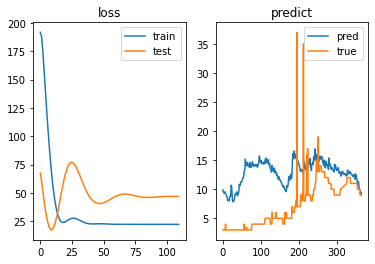

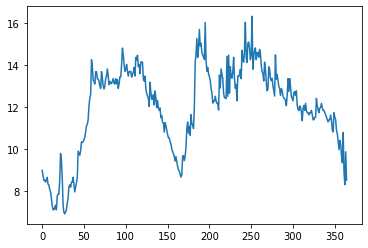


안동, 50CM 일 토양수분(%)

[Epoch: 10] train loss : 82.57 | test loss : 67.01
[Epoch: 20] train loss : 26.91 | test loss : 17.52


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 30.51 | test loss : 25.62
[Epoch: 40] train loss : 25.60 | test loss : 22.17
[Epoch: 50] train loss : 25.21 | test loss : 19.25
[Epoch: 60] train loss : 24.82 | test loss : 19.29
[Epoch: 70] train loss : 24.72 | test loss : 19.97
[Epoch: 80] train loss : 24.67 | test loss : 19.53
[Epoch: 90] train loss : 24.66 | test loss : 19.51
[Epoch: 100] train loss : 24.65 | test loss : 19.53
[Epoch: 110] train loss : 24.65 | test loss : 19.56

Early Stopping
Epoch : 119


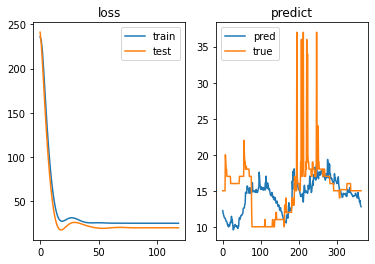

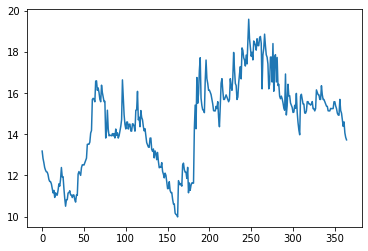


안동, 1.5M 평균 기온(°C)

[Epoch: 10] train loss : 115.57 | test loss : 94.59
[Epoch: 20] train loss : 26.40 | test loss : 21.88


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  9.09 | test loss : 10.35
[Epoch: 40] train loss :  9.28 | test loss : 10.99
[Epoch: 50] train loss :  7.93 | test loss : 10.12
[Epoch: 60] train loss :  6.97 | test loss :  9.24
[Epoch: 70] train loss :  6.74 | test loss :  8.71
[Epoch: 80] train loss :  6.58 | test loss :  8.41
[Epoch: 90] train loss :  6.45 | test loss :  8.52
[Epoch: 100] train loss :  6.36 | test loss :  8.69
[Epoch: 110] train loss :  6.29 | test loss :  8.79
[Epoch: 120] train loss :  6.23 | test loss :  8.80
[Epoch: 130] train loss :  6.18 | test loss :  8.79
[Epoch: 140] train loss :  6.13 | test loss :  8.83
[Epoch: 150] train loss :  6.09 | test loss :  8.88
[Epoch: 160] train loss :  6.05 | test loss :  8.91
[Epoch: 170] train loss :  6.02 | test loss :  8.94
[Epoch: 180] train loss :  5.99 | test loss :  8.96

Early Stopping
Epoch : 180


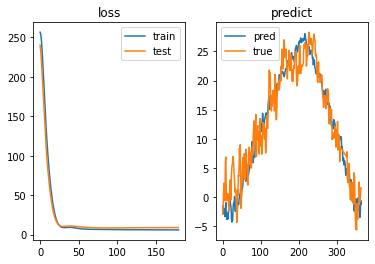

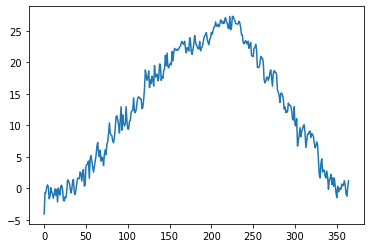


안동, 평균 지면온도(°C)

[Epoch: 10] train loss : 186.88 | test loss : 134.53
[Epoch: 20] train loss : 58.38 | test loss : 33.87


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 15.31 | test loss :  9.79
[Epoch: 40] train loss :  9.66 | test loss : 12.38
[Epoch: 50] train loss :  9.65 | test loss : 13.95
[Epoch: 60] train loss :  8.67 | test loss : 12.34
[Epoch: 70] train loss :  8.11 | test loss : 10.54
[Epoch: 80] train loss :  8.01 | test loss :  9.61
[Epoch: 90] train loss :  7.99 | test loss :  9.40
[Epoch: 100] train loss :  7.97 | test loss :  9.53
[Epoch: 110] train loss :  7.96 | test loss :  9.69
[Epoch: 120] train loss :  7.96 | test loss :  9.75
[Epoch: 130] train loss :  7.96 | test loss :  9.75
[Epoch: 140] train loss :  7.96 | test loss :  9.72
[Epoch: 150] train loss :  7.96 | test loss :  9.70
[Epoch: 160] train loss :  7.96 | test loss :  9.70
[Epoch: 170] train loss :  7.96 | test loss :  9.71
[Epoch: 180] train loss :  7.96 | test loss :  9.71

Early Stopping
Epoch : 189


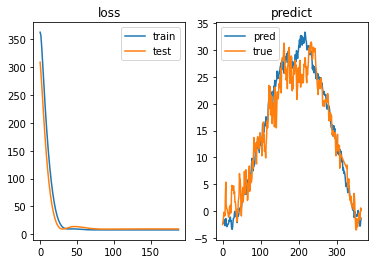

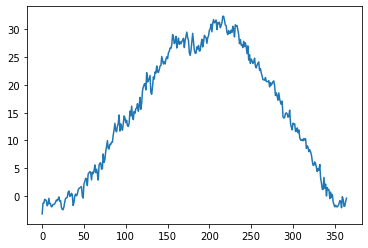


안동, 5CM 평균 지중온도(°C)

[Epoch: 10] train loss : 168.46 | test loss : 147.61
[Epoch: 20] train loss : 47.47 | test loss : 38.87


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  9.28 | test loss :  8.74
[Epoch: 40] train loss :  5.53 | test loss :  7.58
[Epoch: 50] train loss :  5.36 | test loss :  7.97
[Epoch: 60] train loss :  4.27 | test loss :  7.27
[Epoch: 70] train loss :  3.81 | test loss :  6.69
[Epoch: 80] train loss :  3.74 | test loss :  6.28
[Epoch: 90] train loss :  3.71 | test loss :  6.07
[Epoch: 100] train loss :  3.69 | test loss :  6.07
[Epoch: 110] train loss :  3.69 | test loss :  6.13
[Epoch: 120] train loss :  3.69 | test loss :  6.18
[Epoch: 130] train loss :  3.69 | test loss :  6.19
[Epoch: 140] train loss :  3.69 | test loss :  6.17
[Epoch: 150] train loss :  3.69 | test loss :  6.15
[Epoch: 160] train loss :  3.69 | test loss :  6.15
[Epoch: 170] train loss :  3.69 | test loss :  6.16
[Epoch: 180] train loss :  3.69 | test loss :  6.16
[Epoch: 190] train loss :  3.69 | test loss :  6.16

Early Stopping
Epoch : 194


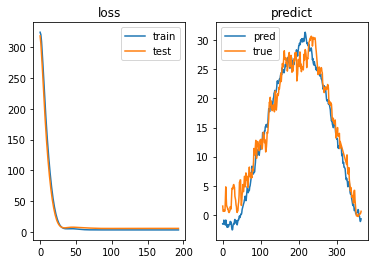

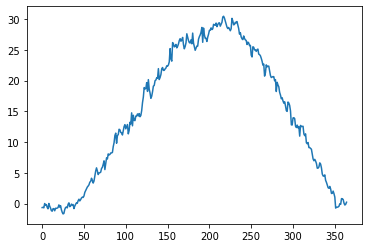


안동, 30CM 평균 지중온도(°C)

[Epoch: 10] train loss : 159.89 | test loss : 142.13
[Epoch: 20] train loss : 40.77 | test loss : 34.40


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  6.43 | test loss :  6.91
[Epoch: 40] train loss :  3.51 | test loss :  5.61
[Epoch: 50] train loss :  3.30 | test loss :  5.75
[Epoch: 60] train loss :  2.17 | test loss :  4.95
[Epoch: 70] train loss :  1.71 | test loss :  4.46
[Epoch: 80] train loss :  1.67 | test loss :  4.18
[Epoch: 90] train loss :  1.64 | test loss :  4.01
[Epoch: 100] train loss :  1.62 | test loss :  4.00
[Epoch: 110] train loss :  1.61 | test loss :  4.06
[Epoch: 120] train loss :  1.61 | test loss :  4.09
[Epoch: 130] train loss :  1.61 | test loss :  4.10
[Epoch: 140] train loss :  1.61 | test loss :  4.08
[Epoch: 150] train loss :  1.61 | test loss :  4.07
[Epoch: 160] train loss :  1.61 | test loss :  4.07
[Epoch: 170] train loss :  1.61 | test loss :  4.08
[Epoch: 180] train loss :  1.61 | test loss :  4.08
[Epoch: 190] train loss :  1.61 | test loss :  4.08

Early Stopping
Epoch : 197


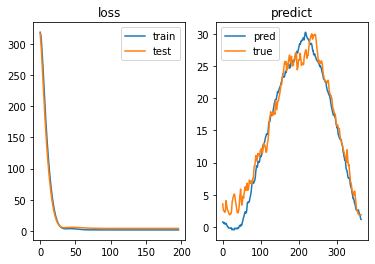

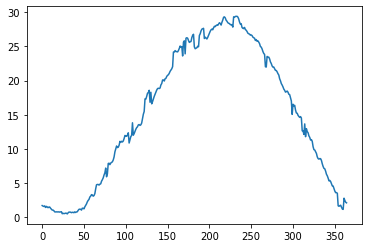


안동, 0.5M 일 지중온도(°C)

[Epoch: 10] train loss : 143.88 | test loss : 121.12
[Epoch: 20] train loss : 30.43 | test loss : 23.44


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  4.32 | test loss :  4.98
[Epoch: 40] train loss :  3.67 | test loss :  5.42
[Epoch: 50] train loss :  2.79 | test loss :  4.56
[Epoch: 60] train loss :  1.51 | test loss :  3.41
[Epoch: 70] train loss :  1.23 | test loss :  2.85
[Epoch: 80] train loss :  1.20 | test loss :  2.58
[Epoch: 90] train loss :  1.15 | test loss :  2.52
[Epoch: 100] train loss :  1.14 | test loss :  2.59
[Epoch: 110] train loss :  1.14 | test loss :  2.65
[Epoch: 120] train loss :  1.14 | test loss :  2.66
[Epoch: 130] train loss :  1.13 | test loss :  2.63
[Epoch: 140] train loss :  1.13 | test loss :  2.61
[Epoch: 150] train loss :  1.13 | test loss :  2.62
[Epoch: 160] train loss :  1.13 | test loss :  2.63
[Epoch: 170] train loss :  1.13 | test loss :  2.63
[Epoch: 180] train loss :  1.13 | test loss :  2.63

Early Stopping
Epoch : 189


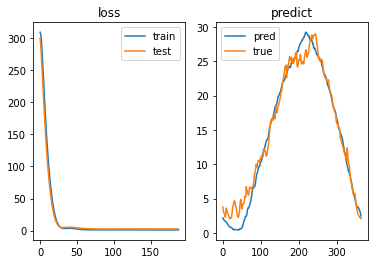

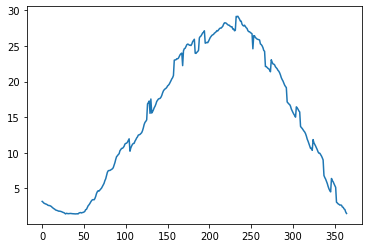


안동, 1.0M 일 지중온도(°C)

[Epoch: 10] train loss : 152.89 | test loss : 133.67


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 20] train loss : 35.44 | test loss : 29.19
[Epoch: 30] train loss :  4.34 | test loss :  4.42
[Epoch: 40] train loss :  3.02 | test loss :  3.74
[Epoch: 50] train loss :  2.36 | test loss :  3.07
[Epoch: 60] train loss :  1.12 | test loss :  2.18
[Epoch: 70] train loss :  0.80 | test loss :  1.86
[Epoch: 80] train loss :  0.77 | test loss :  1.62
[Epoch: 90] train loss :  0.73 | test loss :  1.51
[Epoch: 100] train loss :  0.71 | test loss :  1.56
[Epoch: 110] train loss :  0.71 | test loss :  1.61
[Epoch: 120] train loss :  0.71 | test loss :  1.61
[Epoch: 130] train loss :  0.71 | test loss :  1.59
[Epoch: 140] train loss :  0.71 | test loss :  1.58
[Epoch: 150] train loss :  0.71 | test loss :  1.58
[Epoch: 160] train loss :  0.71 | test loss :  1.59
[Epoch: 170] train loss :  0.71 | test loss :  1.59
[Epoch: 180] train loss :  0.71 | test loss :  1.59
[Epoch: 190] train loss :  0.71 | test loss :  1.59

Early Stopping
Epoch : 191


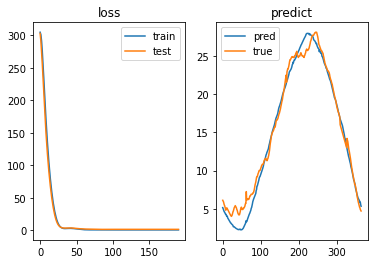

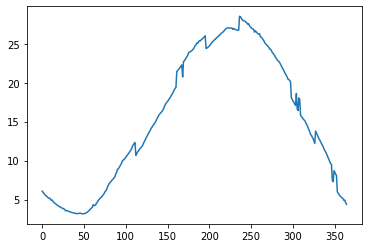


안동, 일사량

[Epoch: 10] train loss : 108.85 | test loss : 102.33
[Epoch: 20] train loss : 37.18 | test loss : 40.83


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 32.59 | test loss : 42.15
[Epoch: 40] train loss : 30.98 | test loss : 41.97
[Epoch: 50] train loss : 29.29 | test loss : 39.82
[Epoch: 60] train loss : 28.91 | test loss : 38.49
[Epoch: 70] train loss : 28.78 | test loss : 38.47
[Epoch: 80] train loss : 28.72 | test loss : 38.60
[Epoch: 90] train loss : 28.70 | test loss : 38.49
[Epoch: 100] train loss : 28.69 | test loss : 38.56
[Epoch: 110] train loss : 28.69 | test loss : 38.57
[Epoch: 120] train loss : 28.69 | test loss : 38.53
[Epoch: 130] train loss : 28.69 | test loss : 38.53
[Epoch: 140] train loss : 28.69 | test loss : 38.54
[Epoch: 150] train loss : 28.69 | test loss : 38.54
[Epoch: 160] train loss : 28.69 | test loss : 38.54

Early Stopping
Epoch : 164


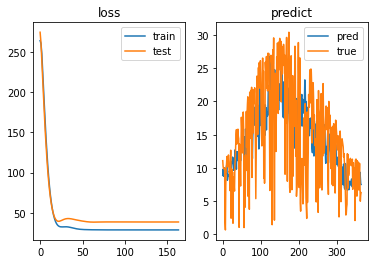

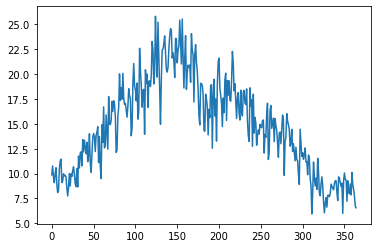


안동, 일조시간

[Epoch: 10] train loss : 13.62 | test loss : 12.18
[Epoch: 20] train loss : 13.38 | test loss : 15.37


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 11.91 | test loss : 12.75
[Epoch: 40] train loss : 11.69 | test loss : 12.53
[Epoch: 50] train loss : 11.59 | test loss : 12.82
[Epoch: 60] train loss : 11.53 | test loss : 12.57
[Epoch: 70] train loss : 11.49 | test loss : 12.63
[Epoch: 80] train loss : 11.43 | test loss : 12.62
[Epoch: 90] train loss : 11.37 | test loss : 12.62
[Epoch: 100] train loss : 11.30 | test loss : 12.64
[Epoch: 110] train loss : 11.24 | test loss : 12.63

Early Stopping
Epoch : 110


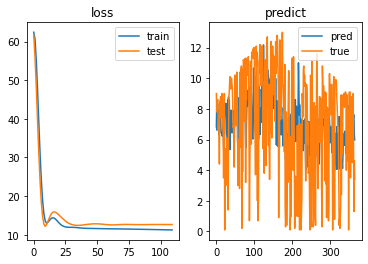

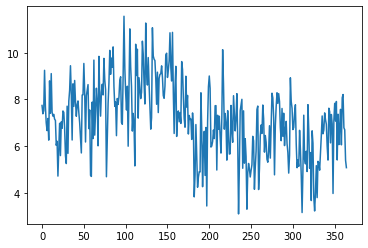


안동, 최대풍속

[Epoch: 10] train loss :  7.39 | test loss : 10.40
[Epoch: 20] train loss :  8.10 | test loss : 13.15


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  6.62 | test loss : 11.31
[Epoch: 40] train loss :  6.19 | test loss : 10.61
[Epoch: 50] train loss :  6.07 | test loss : 11.05
[Epoch: 60] train loss :  6.01 | test loss : 10.62
[Epoch: 70] train loss :  6.00 | test loss : 10.78
[Epoch: 80] train loss :  5.99 | test loss : 10.72
[Epoch: 90] train loss :  5.99 | test loss : 10.72
[Epoch: 100] train loss :  5.99 | test loss : 10.73
[Epoch: 110] train loss :  5.99 | test loss : 10.72
[Epoch: 120] train loss :  5.99 | test loss : 10.73
[Epoch: 130] train loss :  5.99 | test loss : 10.72

Early Stopping
Epoch : 136


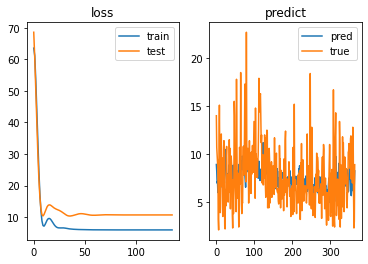

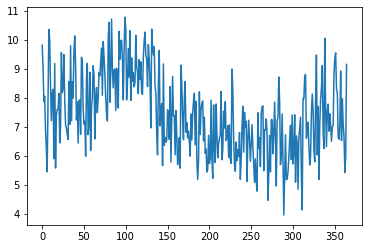


제주, 1.5M 평균 습도(%)

[Epoch: 10] train loss : 4557.05 | test loss : 4562.83
[Epoch: 20] train loss : 3340.27 | test loss : 3347.55


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 2325.10 | test loss : 2336.69
[Epoch: 40] train loss : 1552.54 | test loss : 1571.49
[Epoch: 50] train loss : 1011.17 | test loss : 1036.73
[Epoch: 60] train loss : 653.71 | test loss : 684.02
[Epoch: 70] train loss : 430.20 | test loss : 463.64
[Epoch: 80] train loss : 297.33 | test loss : 332.82
[Epoch: 90] train loss : 221.92 | test loss : 258.88
[Epoch: 100] train loss : 180.88 | test loss : 219.01
[Epoch: 110] train loss : 159.36 | test loss : 198.48
[Epoch: 120] train loss : 148.43 | test loss : 188.39
[Epoch: 130] train loss : 143.06 | test loss : 183.66
[Epoch: 140] train loss : 140.48 | test loss : 181.54
[Epoch: 150] train loss : 139.29 | test loss : 180.63
[Epoch: 160] train loss : 138.76 | test loss : 180.23
[Epoch: 170] train loss : 138.53 | test loss : 180.05
[Epoch: 180] train loss : 138.44 | test loss : 179.94
[Epoch: 190] train loss : 138.41 | test loss : 179.87
[Epoch: 200] train loss : 138.39 | test loss : 179.82
[Epoch: 210] train loss : 138

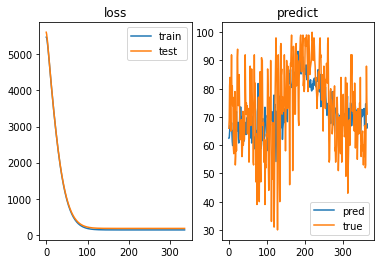

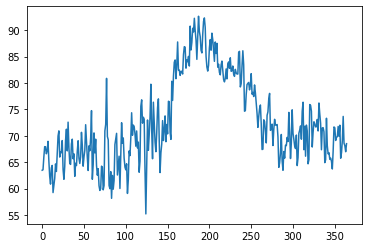


제주, 10CM 일 토양수분(%)

[Epoch: 10] train loss : 196.55 | test loss : 212.53
[Epoch: 20] train loss : 74.50 | test loss : 64.29


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 70.47 | test loss : 45.95
[Epoch: 40] train loss : 69.22 | test loss : 48.84
[Epoch: 50] train loss : 65.50 | test loss : 53.51
[Epoch: 60] train loss : 65.58 | test loss : 54.48
[Epoch: 70] train loss : 65.24 | test loss : 52.23
[Epoch: 80] train loss : 65.17 | test loss : 51.38
[Epoch: 90] train loss : 65.15 | test loss : 51.68
[Epoch: 100] train loss : 65.13 | test loss : 52.03
[Epoch: 110] train loss : 65.13 | test loss : 51.97
[Epoch: 120] train loss : 65.13 | test loss : 51.83

Early Stopping
Epoch : 128


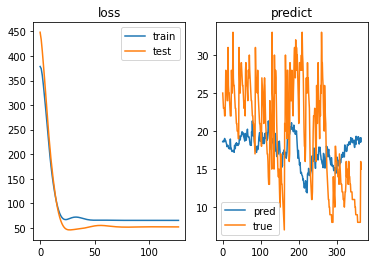

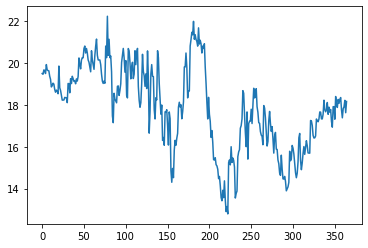


제주, 20CM 일 토양수분(%)

[Epoch: 10] train loss : 173.52 | test loss : 420.32
[Epoch: 20] train loss : 72.07 | test loss : 154.22


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 75.71 | test loss : 85.80
[Epoch: 40] train loss : 71.61 | test loss : 111.61
[Epoch: 50] train loss : 68.88 | test loss : 149.50
[Epoch: 60] train loss : 69.05 | test loss : 150.33
[Epoch: 70] train loss : 68.63 | test loss : 135.89
[Epoch: 80] train loss : 68.63 | test loss : 133.58
[Epoch: 90] train loss : 68.59 | test loss : 138.00
[Epoch: 100] train loss : 68.59 | test loss : 138.85
[Epoch: 110] train loss : 68.58 | test loss : 137.44
[Epoch: 120] train loss : 68.58 | test loss : 137.28
[Epoch: 130] train loss : 68.58 | test loss : 137.71

Early Stopping
Epoch : 131


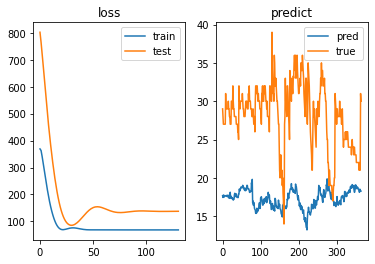

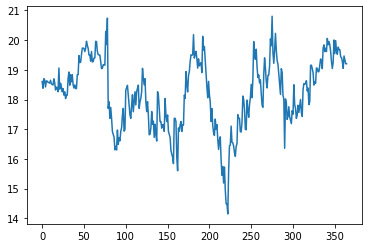


제주, 30CM 일 토양수분(%)

[Epoch: 10] train loss : 149.14 | test loss : 573.82
[Epoch: 20] train loss : 75.83 | test loss : 251.44


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 82.90 | test loss : 196.75
[Epoch: 40] train loss : 75.73 | test loss : 268.02
[Epoch: 50] train loss : 75.98 | test loss : 302.50
[Epoch: 60] train loss : 75.16 | test loss : 275.69
[Epoch: 70] train loss : 75.07 | test loss : 264.45
[Epoch: 80] train loss : 74.87 | test loss : 274.53
[Epoch: 90] train loss : 74.74 | test loss : 275.66
[Epoch: 100] train loss : 74.60 | test loss : 271.51
[Epoch: 110] train loss : 74.47 | test loss : 271.83
[Epoch: 120] train loss : 74.33 | test loss : 272.22

Early Stopping
Epoch : 127


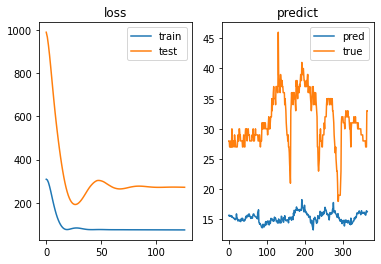

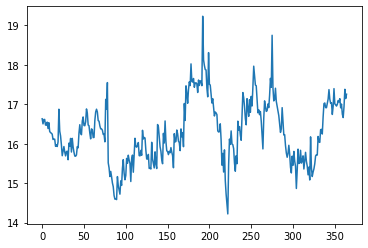


제주, 50CM 일 토양수분(%)

[Epoch: 10] train loss : 123.54 | test loss : 524.51
[Epoch: 20] train loss : 92.73 | test loss : 257.27


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 91.99 | test loss : 283.71
[Epoch: 40] train loss : 89.62 | test loss : 362.76
[Epoch: 50] train loss : 89.09 | test loss : 340.38
[Epoch: 60] train loss : 88.99 | test loss : 318.01
[Epoch: 70] train loss : 88.85 | test loss : 332.67
[Epoch: 80] train loss : 88.84 | test loss : 333.36
[Epoch: 90] train loss : 88.83 | test loss : 328.52
[Epoch: 100] train loss : 88.82 | test loss : 331.02
[Epoch: 110] train loss : 88.82 | test loss : 330.86
[Epoch: 120] train loss : 88.82 | test loss : 330.27

Early Stopping
Epoch : 123


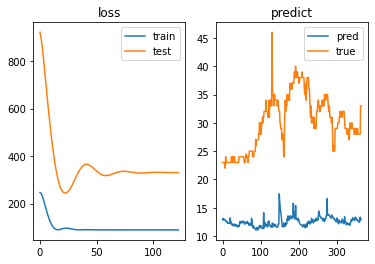

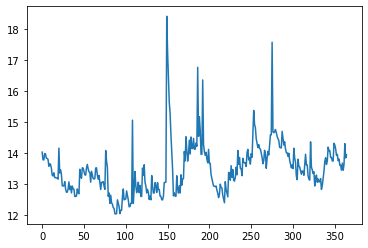


제주, 1.5M 평균 기온(°C)

[Epoch: 10] train loss : 151.32 | test loss : 124.65


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 20] train loss : 33.77 | test loss : 26.72
[Epoch: 30] train loss :  8.51 | test loss : 11.04
[Epoch: 40] train loss :  7.94 | test loss : 11.53
[Epoch: 50] train loss :  6.65 | test loss :  9.27
[Epoch: 60] train loss :  5.49 | test loss :  7.82
[Epoch: 70] train loss :  5.27 | test loss :  7.50
[Epoch: 80] train loss :  5.21 | test loss :  7.36
[Epoch: 90] train loss :  5.17 | test loss :  7.40
[Epoch: 100] train loss :  5.16 | test loss :  7.48
[Epoch: 110] train loss :  5.16 | test loss :  7.47
[Epoch: 120] train loss :  5.15 | test loss :  7.44
[Epoch: 130] train loss :  5.15 | test loss :  7.43
[Epoch: 140] train loss :  5.15 | test loss :  7.44
[Epoch: 150] train loss :  5.15 | test loss :  7.44
[Epoch: 160] train loss :  5.15 | test loss :  7.44
[Epoch: 170] train loss :  5.15 | test loss :  7.44
[Epoch: 180] train loss :  5.12 | test loss :  7.40

Early Stopping
Epoch : 181


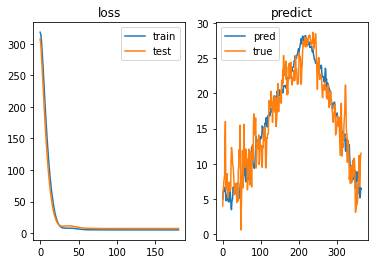

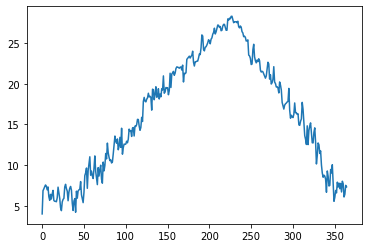


제주, 평균 지면온도(°C)

[Epoch: 10] train loss : 198.87 | test loss : 148.40
[Epoch: 20] train loss : 54.89 | test loss : 31.59


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 17.10 | test loss : 10.55
[Epoch: 40] train loss : 14.68 | test loss : 12.49
[Epoch: 50] train loss : 13.92 | test loss : 10.81
[Epoch: 60] train loss : 12.52 | test loss :  8.15
[Epoch: 70] train loss : 12.08 | test loss :  7.35
[Epoch: 80] train loss : 12.02 | test loss :  7.04
[Epoch: 90] train loss : 11.98 | test loss :  7.01
[Epoch: 100] train loss : 11.96 | test loss :  7.11
[Epoch: 110] train loss : 11.95 | test loss :  7.20
[Epoch: 120] train loss : 11.95 | test loss :  7.20
[Epoch: 130] train loss : 11.95 | test loss :  7.17
[Epoch: 140] train loss : 11.95 | test loss :  7.15
[Epoch: 150] train loss : 11.95 | test loss :  7.16
[Epoch: 160] train loss : 11.95 | test loss :  7.16
[Epoch: 170] train loss : 11.95 | test loss :  7.16
[Epoch: 180] train loss : 11.95 | test loss :  7.16

Early Stopping
Epoch : 186


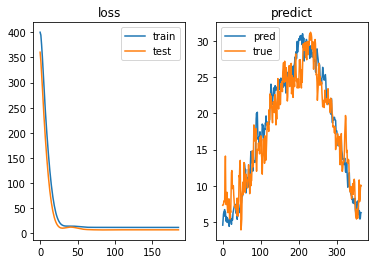

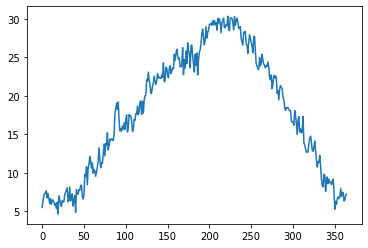


제주, 5CM 평균 지중온도(°C)

[Epoch: 10] train loss : 191.80 | test loss : 170.31
[Epoch: 20] train loss : 47.72 | test loss : 36.88


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  9.30 | test loss :  8.26
[Epoch: 40] train loss :  6.28 | test loss :  7.91
[Epoch: 50] train loss :  5.48 | test loss :  7.43
[Epoch: 60] train loss :  4.13 | test loss :  6.05
[Epoch: 70] train loss :  3.71 | test loss :  5.62
[Epoch: 80] train loss :  3.62 | test loss :  5.22
[Epoch: 90] train loss :  3.58 | test loss :  5.05
[Epoch: 100] train loss :  3.57 | test loss :  5.10
[Epoch: 110] train loss :  3.56 | test loss :  5.17
[Epoch: 120] train loss :  3.56 | test loss :  5.19
[Epoch: 130] train loss :  3.56 | test loss :  5.17
[Epoch: 140] train loss :  3.56 | test loss :  5.16
[Epoch: 150] train loss :  3.56 | test loss :  5.16
[Epoch: 160] train loss :  3.56 | test loss :  5.16
[Epoch: 170] train loss :  3.56 | test loss :  5.16
[Epoch: 180] train loss :  3.56 | test loss :  5.16
[Epoch: 190] train loss :  3.56 | test loss :  5.16

Early Stopping
Epoch : 192


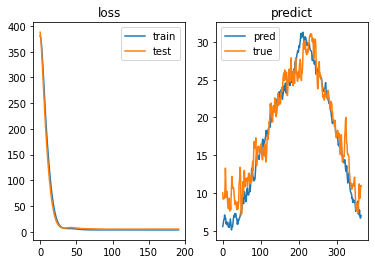

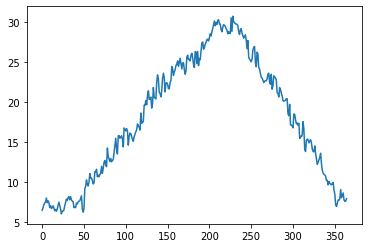


제주, 30CM 평균 지중온도(°C)

[Epoch: 10] train loss : 184.07 | test loss : 155.53
[Epoch: 20] train loss : 42.21 | test loss : 31.46


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  6.25 | test loss :  6.46
[Epoch: 40] train loss :  4.12 | test loss :  5.85
[Epoch: 50] train loss :  3.18 | test loss :  4.52
[Epoch: 60] train loss :  1.83 | test loss :  2.78
[Epoch: 70] train loss :  1.46 | test loss :  2.24
[Epoch: 80] train loss :  1.41 | test loss :  2.21
[Epoch: 90] train loss :  1.36 | test loss :  2.16
[Epoch: 100] train loss :  1.31 | test loss :  2.17
[Epoch: 110] train loss :  1.28 | test loss :  2.19
[Epoch: 120] train loss :  1.26 | test loss :  2.17
[Epoch: 130] train loss :  1.24 | test loss :  2.16
[Epoch: 140] train loss :  1.21 | test loss :  2.16
[Epoch: 150] train loss :  1.20 | test loss :  2.16
[Epoch: 160] train loss :  1.18 | test loss :  2.16
[Epoch: 170] train loss :  1.16 | test loss :  2.16
[Epoch: 180] train loss :  1.15 | test loss :  2.16
[Epoch: 190] train loss :  1.13 | test loss :  2.15
[Epoch: 200] train loss :  1.12 | test loss :  2.15
[Epoch: 210] train loss :  1.11 | test loss :  2.15
[Epoch: 220] train 

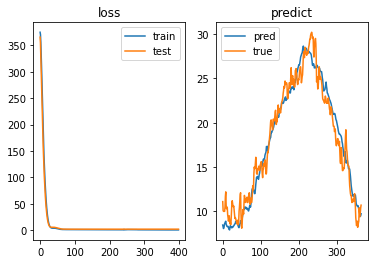

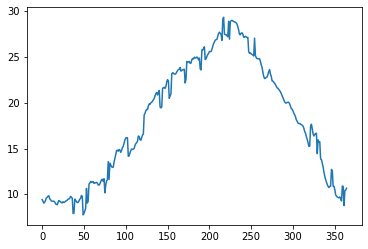


제주, 0.5M 일 지중온도(°C)

[Epoch: 10] train loss : 158.00 | test loss : 137.17
[Epoch: 20] train loss : 30.94 | test loss : 21.61


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  4.61 | test loss :  3.81
[Epoch: 40] train loss :  4.69 | test loss :  5.31
[Epoch: 50] train loss :  2.94 | test loss :  2.78
[Epoch: 60] train loss :  1.63 | test loss :  1.60
[Epoch: 70] train loss :  1.46 | test loss :  1.27
[Epoch: 80] train loss :  1.39 | test loss :  1.14
[Epoch: 90] train loss :  1.34 | test loss :  1.18
[Epoch: 100] train loss :  1.33 | test loss :  1.18
[Epoch: 110] train loss :  1.33 | test loss :  1.20
[Epoch: 120] train loss :  1.32 | test loss :  1.18
[Epoch: 130] train loss :  1.32 | test loss :  1.17
[Epoch: 140] train loss :  1.32 | test loss :  1.17
[Epoch: 150] train loss :  1.32 | test loss :  1.17
[Epoch: 160] train loss :  1.32 | test loss :  1.18
[Epoch: 170] train loss :  1.32 | test loss :  1.17

Early Stopping
Epoch : 179


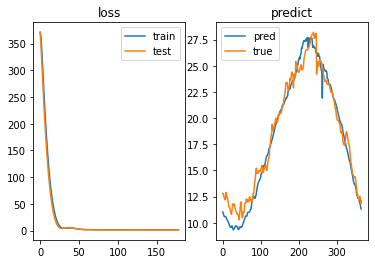

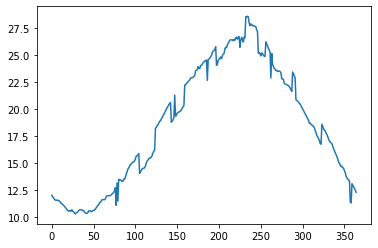


제주, 1.0M 일 지중온도(°C)

[Epoch: 10] train loss : 155.63 | test loss : 141.48
[Epoch: 20] train loss : 27.85 | test loss : 21.45


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  4.64 | test loss :  2.06
[Epoch: 40] train loss :  4.13 | test loss :  3.92
[Epoch: 50] train loss :  2.63 | test loss :  2.67
[Epoch: 60] train loss :  1.24 | test loss :  1.01
[Epoch: 70] train loss :  1.00 | test loss :  0.86
[Epoch: 80] train loss :  0.96 | test loss :  0.84
[Epoch: 90] train loss :  0.91 | test loss :  0.70
[Epoch: 100] train loss :  0.89 | test loss :  0.72
[Epoch: 110] train loss :  0.89 | test loss :  0.75
[Epoch: 120] train loss :  0.89 | test loss :  0.74
[Epoch: 130] train loss :  0.89 | test loss :  0.73
[Epoch: 140] train loss :  0.89 | test loss :  0.73
[Epoch: 150] train loss :  0.89 | test loss :  0.73
[Epoch: 160] train loss :  0.89 | test loss :  0.73
[Epoch: 170] train loss :  0.89 | test loss :  0.73
[Epoch: 180] train loss :  0.89 | test loss :  0.73
[Epoch: 190] train loss :  0.89 | test loss :  0.73

Early Stopping
Epoch : 193


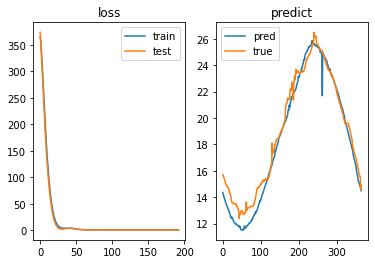

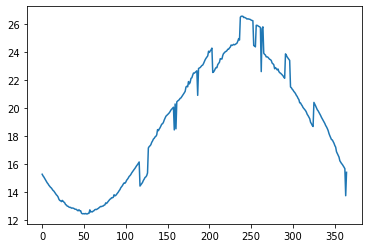


제주, 일사량

[Epoch: 10] train loss : 108.55 | test loss : 97.01
[Epoch: 20] train loss : 42.46 | test loss : 44.87


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 37.92 | test loss : 50.30
[Epoch: 40] train loss : 36.81 | test loss : 53.53
[Epoch: 50] train loss : 35.20 | test loss : 49.85
[Epoch: 60] train loss : 34.87 | test loss : 47.67
[Epoch: 70] train loss : 34.76 | test loss : 47.31
[Epoch: 80] train loss : 34.70 | test loss : 47.52
[Epoch: 90] train loss : 34.68 | test loss : 47.80
[Epoch: 100] train loss : 34.68 | test loss : 47.84
[Epoch: 110] train loss : 34.67 | test loss : 47.73
[Epoch: 120] train loss : 34.67 | test loss : 47.70

Early Stopping
Epoch : 122


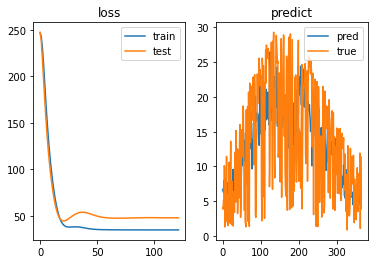

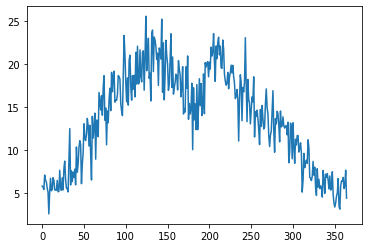


제주, 일조시간

[Epoch: 10] train loss : 13.54 | test loss : 13.57
[Epoch: 20] train loss : 13.12 | test loss : 16.34


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss : 12.46 | test loss : 13.95
[Epoch: 40] train loss : 12.07 | test loss : 14.61
[Epoch: 50] train loss : 12.27 | test loss : 14.11
[Epoch: 60] train loss : 12.21 | test loss : 14.34
[Epoch: 70] train loss : 12.06 | test loss : 14.21
[Epoch: 80] train loss : 11.86 | test loss : 14.32
[Epoch: 90] train loss : 11.59 | test loss : 14.41
[Epoch: 100] train loss : 11.35 | test loss : 14.74

Early Stopping
Epoch : 109


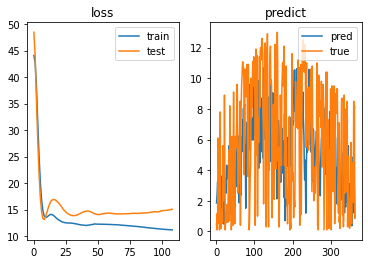

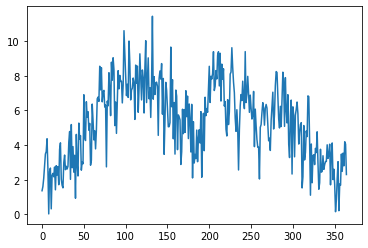


제주, 최대풍속

[Epoch: 10] train loss : 10.98 | test loss :  8.57
[Epoch: 20] train loss : 10.85 | test loss : 16.60


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365])) that is different to the input size (torch.Size([1, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 30] train loss :  8.17 | test loss :  9.82
[Epoch: 40] train loss :  7.88 | test loss :  9.50
[Epoch: 50] train loss :  7.74 | test loss : 10.67
[Epoch: 60] train loss :  7.67 | test loss :  9.88
[Epoch: 70] train loss :  7.65 | test loss : 10.02
[Epoch: 80] train loss :  7.64 | test loss : 10.06
[Epoch: 90] train loss :  7.64 | test loss :  9.98
[Epoch: 100] train loss :  7.64 | test loss : 10.04
[Epoch: 110] train loss :  7.64 | test loss : 10.00

Early Stopping
Epoch : 110


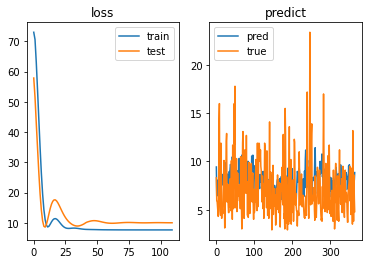

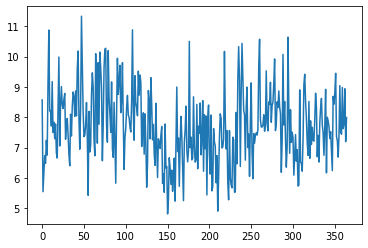

tensor([[[67.3834, 65.5056, 70.8390,  ..., 69.5056, 69.7278, 70.2834],
         [ 8.5651,  9.6298, 10.4149,  ...,  8.8993,  9.0834,  9.8887],
         [15.1329, 14.7666, 14.3980,  ..., 14.8812, 14.5068, 14.9347],
         ...,
         [ 8.3377,  8.7635,  8.7691,  ...,  8.4763,  6.8417,  4.2380],
         [ 6.5867,  4.6192,  6.2611,  ...,  6.3602,  5.3307,  4.9472],
         [ 7.0020,  4.5045,  3.7768,  ...,  3.1548,  4.0958,  7.2086]],

        [[62.9487, 63.9400, 67.7171,  ..., 66.2728, 69.7169, 71.7173],
         [ 4.8110,  4.4626,  4.8373,  ...,  7.0535,  6.8519,  7.5673],
         [ 8.9565,  9.0074,  9.0236,  ..., 10.4843,  9.6578,  9.6778],
         ...,
         [ 9.8710, 10.7620,  9.6956,  ...,  7.6761,  6.6897,  6.5607],
         [ 7.7434,  7.3881,  7.5178,  ...,  6.7049,  5.3981,  5.0839],
         [ 9.8279,  9.1399,  7.8850,  ...,  5.4365,  5.9776,  9.1648]],

        [[63.4724, 63.5541, 65.9692,  ..., 68.1162, 66.9757, 68.5018],
         [19.5051, 19.4720, 19.6792,  ..., 18

In [16]:
pred_list = []
for i in range(3) :
    pred_list_pos = list()
    for j in range(14):
        model = Climate_LSTM(input_dim, seq_len, n_layers, hidden_dim, output_dim, device).to(device)
        criterion = nn.MSELoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        print(f"\n{pos_list[i]}, {feature_list[j]}\n")
        trained_model = train_and_eval(model, dataset_list[i][j][0], dataset_list[i][j][1], num_epochs, criterion, optimizer, early_stop_patience)
        criterion = nn.MSELoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        trained_model = train_again(trained_model, criterion, optimizer, dataset_list[i][j][1])
        pred_x_list = []
        for k, (x, y) in enumerate(dataset_list[i][j][1]) :
            pred_x_list.append(x)
        logit = model(torch.unsqueeze(torch.FloatTensor(x).to(device), 0)) #
        predicted = torch.flatten(logit)
        plt.plot(np.arange(predicted.shape[0]), predicted.detach().cpu().numpy())
        plt.show()
        pred_list_pos.append(predicted)
    pred_list_pos = torch.stack(pred_list_pos, 0)
    pred_list.append(pred_list_pos)
pred_list = torch.stack(pred_list, 0)
pred_list

농작물 생산량 LSTM 모델

In [17]:
class Crop_LSTM(nn.Module):
    def __init__(self, input_dim, seq_len, n_layers, hidden_dim, output_dim, device):
        super(Crop_LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim,
                            num_layers=self.n_layers,
                            batch_first=True)
        self.out = nn.Linear(self.hidden_dim, self.output_dim, bias=True)

    def forward(self, x): # 365*13
        h_0 = self._init_state()
        x, _ = self.lstm(x, h_0) # 365 * 100 
        h_t = x[:, -1] # 1 * 100
        logit = self.out(h_t)
        return logit

    def _init_state(self):
        new_cell_state = torch.zeros(self.n_layers, self.seq_len, self.hidden_dim).to(self.device)
        new_hidden_state = torch.zeros(self.n_layers, self.seq_len, self.hidden_dim).to(self.device)
        self.hidden = (new_hidden_state, new_cell_state)

모델 하이퍼파라미터 세팅

In [18]:
n_layers = 1
hidden_dim = 7
seq_len = 365
input_dim = 14
output_dim = 1
num_epochs = 1000
early_stop_patience = 100

농작물 데이터 전처리

In [19]:
Chuncheon_Grain = pd.read_csv(path_data+"/Chuncheon_Grain.csv")
Chuncheon_Grain = Chuncheon_Grain.iloc[:,1:]
Chuncheon_Grain_np = Chuncheon_Grain.to_numpy()
Chuncheon_Fruit = pd.read_csv(path_data+"/Chuncheon_Fruit.csv")
Chuncheon_Fruit = Chuncheon_Fruit.iloc[:,1:]
Chuncheon_Fruit_np = Chuncheon_Fruit.to_numpy()
Andong_Grain = pd.read_csv(path_data+"/Andong_Grain.csv")
Andong_Grain = Andong_Grain.iloc[:,1:]
Andong_Grain_np = Andong_Grain.to_numpy()
Andong_Fruit = pd.read_csv(path_data+"/Andong_Fruit.csv")
Andong_Fruit = Andong_Fruit.iloc[:,1:]
Andong_Fruit_np = Andong_Fruit.to_numpy()
Jeju_Grain = pd.read_csv(path_data+"/Jeju_Grain.csv")
Jeju_Grain = Jeju_Grain.iloc[:,1:]
Jeju_Grain_np = Jeju_Grain.to_numpy()
Jeju_Fruit = pd.read_csv(path_data+"/Jeju_Fruit.csv")
Jeju_Fruit = Jeju_Fruit.iloc[:,1:]
Jeju_Fruit_np = Jeju_Fruit.to_numpy()
Grain = [Chuncheon_Grain_np, Andong_Grain_np, Jeju_Grain_np]
Fruit = [Chuncheon_Fruit_np, Andong_Fruit_np, Jeju_Fruit_np]

데이터 넘파이 배열로 적재

In [20]:
pred_list = pred_list.reshape(3, 1, 365, 14)
pred_list = pred_list.detach().cpu().numpy()
pred_list.shape

(3, 1, 365, 14)

훈련 데이터 및 테스트 데이터 셋 분류

In [21]:
ss = StandardScaler()

climate_new = []
dataloader_list = []

for i in range(3) :
  climate_new_np = np.concatenate([climate[i], pred_list[i]], 0)
  x_scaled = ss.fit_transform(climate_new_np.reshape(-1, 14))
  x_scaled = x_scaled.reshape(11, 365, 14)
  climate_new.append(x_scaled)
  x_train = torch.FloatTensor(x_scaled[1:9, :, :])
  x_test = torch.FloatTensor(x_scaled[9, :, :].reshape(1,365,14))
  Grain_dataloader_list = []
  for j in range(5) : 
    y_scaled = ss.fit_transform(Grain[i][:,j].reshape(-1,1))
    y_train = torch.FloatTensor(y_scaled[:8])
    y_test = torch.FloatTensor(y_scaled[8])
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=365, shuffle=False)
    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=365, shuffle=False)
    Grain_dataloader_list.append((train_loader, test_loader))
    
  Fruit_dataloader_list= []
  for j in range(10) :
    y_scaled = ss.fit_transform(Fruit[i][:,j].reshape(-1,1))
    y_train = torch.FloatTensor(y_scaled[:8])
    y_test = torch.FloatTensor(y_scaled[8])
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=365, shuffle=False)
    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=365, shuffle=False)
    Fruit_dataloader_list.append((train_loader, test_loader))

  dataloader_list.append((Grain_dataloader_list, Fruit_dataloader_list))

훈련 및 평가 함수

In [22]:
def train_and_eval2(model, train_loader, test_loader, epoch, criterion, optimizer, early_stop_patience) :
  train_loss_list = []
  test_loss_list = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = None
  patience = 0

  for e in range(1, epoch+1):
      train_loss = train(model, criterion, optimizer, train_loader)
      test_loss, predicted = evaluate2(model, criterion, test_loader)
      if e%10 == 0 :
          print("[Epoch: %d] train loss : %5.2f | test loss : %5.2f" % (e, train_loss, test_loss))
      train_loss_list.append(train_loss)
      test_loss_list.append(test_loss)
      if e == 1:
        best_loss = test_loss
      if test_loss <= best_loss :
        best_loss = test_loss
        patience = 0
        best_model_wts = copy.deepcopy(model.state_dict())
      else :
        patience += 1
      if (patience >= early_stop_patience) :     
              print('\nEarly Stopping')
              print(f'Epoch : {e}')
              break

  plt.subplot(1, 2, 1)
  plt.plot(np.arange(e), train_loss_list, label='train')
  plt.plot(np.arange(e), test_loss_list, label='test')
  plt.legend()
  plt.title("loss")
  plt.show()

  for x, y in test_loader :
    y_test = y
  predicted = predicted.detach().cpu().numpy()
  
  predicted = predicted.reshape(-1,1)

  print(f"pred : {predicted.item()}, true : {y_test.item()}")
  return model

In [23]:
def train_again2(model, criterion, optimizer, data_loader):
    model.train()
    running_loss = 0
    for i, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        
        model._init_state()
        optimizer.zero_grad()
        logit = model(x)
        loss = criterion(logit, torch.unsqueeze(y,0))
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        train_loss = running_loss / len(data_loader.dataset)
    return model

feature list

In [24]:
feature1 = list(Chuncheon_Grain.columns)
feature2 = list(Chuncheon_Fruit.columns)

모델 훈련 및 평가 진행 후 해당 모델로 농작물 생산량 예측


춘천, 미곡

[Epoch: 10] train loss :  0.94 | test loss :  0.00
[Epoch: 20] train loss :  0.47 | test loss :  0.00
[Epoch: 30] train loss :  0.15 | test loss :  0.07
[Epoch: 40] train loss :  0.12 | test loss :  0.00


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.05 | test loss :  0.02
[Epoch: 60] train loss :  0.10 | test loss :  0.07
[Epoch: 70] train loss :  0.01 | test loss :  0.04
[Epoch: 80] train loss :  0.00 | test loss :  0.10
[Epoch: 90] train loss :  0.00 | test loss :  0.10
[Epoch: 100] train loss :  0.00 | test loss :  0.10
[Epoch: 110] train loss :  0.00 | test loss :  0.09

Early Stopping
Epoch : 113


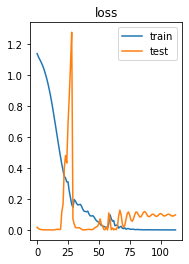

pred : -0.21512234210968018, true : 0.09638967365026474

predicted : 0.4909519553184509

춘천, 맥류

[Epoch: 10] train loss :  0.17 | test loss :  5.88
[Epoch: 20] train loss :  0.04 | test loss :  3.77
[Epoch: 30] train loss :  0.02 | test loss :  2.72
[Epoch: 40] train loss :  0.00 | test loss :  2.96


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.00 | test loss :  3.05
[Epoch: 60] train loss :  0.00 | test loss :  2.78
[Epoch: 70] train loss :  0.00 | test loss :  2.80
[Epoch: 80] train loss :  0.00 | test loss :  2.87
[Epoch: 90] train loss :  0.00 | test loss :  2.85
[Epoch: 100] train loss :  0.00 | test loss :  2.84
[Epoch: 110] train loss :  0.00 | test loss :  2.86
[Epoch: 120] train loss :  0.00 | test loss :  2.86
[Epoch: 130] train loss :  0.00 | test loss :  2.85

Early Stopping
Epoch : 131


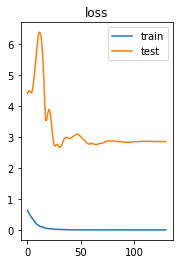

pred : -0.2710816264152527, true : -1.9605313539505005

predicted : -0.5933413505554199

춘천, 잡곡

[Epoch: 10] train loss :  0.27 | test loss :  7.69
[Epoch: 20] train loss :  0.09 | test loss :  6.01
[Epoch: 30] train loss :  0.03 | test loss :  5.70
[Epoch: 40] train loss :  0.01 | test loss :  5.51


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.01 | test loss :  5.78
[Epoch: 60] train loss :  0.00 | test loss :  5.89
[Epoch: 70] train loss :  0.00 | test loss :  5.85
[Epoch: 80] train loss :  0.00 | test loss :  5.84
[Epoch: 90] train loss :  0.00 | test loss :  5.84
[Epoch: 100] train loss :  0.00 | test loss :  5.82

Early Stopping
Epoch : 101


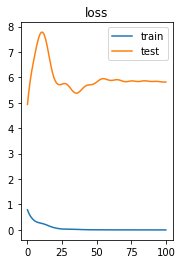

pred : 0.05218210816383362, true : 2.4641354084014893

predicted : 0.2847617566585541

춘천, 두류

[Epoch: 10] train loss :  0.21 | test loss :  8.16
[Epoch: 20] train loss :  0.14 | test loss :  6.47
[Epoch: 30] train loss :  0.12 | test loss :  7.38
[Epoch: 40] train loss :  0.09 | test loss :  7.08


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.06 | test loss :  7.92
[Epoch: 60] train loss :  0.03 | test loss :  8.20
[Epoch: 70] train loss :  0.02 | test loss :  8.84
[Epoch: 80] train loss :  0.01 | test loss :  9.18
[Epoch: 90] train loss :  0.00 | test loss :  9.46
[Epoch: 100] train loss :  0.00 | test loss :  9.85

Early Stopping
Epoch : 101


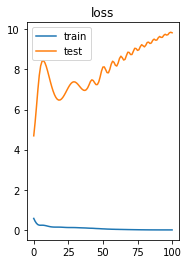

pred : -0.6142280101776123, true : 2.5198822021484375

predicted : -0.07602246105670929

춘천, 서류

[Epoch: 10] train loss :  0.40 | test loss :  4.46
[Epoch: 20] train loss :  0.07 | test loss :  3.38
[Epoch: 30] train loss :  0.01 | test loss :  2.49
[Epoch: 40] train loss :  0.01 | test loss :  2.75


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.12 | test loss :  1.95
[Epoch: 60] train loss :  0.01 | test loss :  2.23
[Epoch: 70] train loss :  0.00 | test loss :  2.56
[Epoch: 80] train loss :  0.00 | test loss :  2.74
[Epoch: 90] train loss :  0.00 | test loss :  2.78
[Epoch: 100] train loss :  0.00 | test loss :  2.67
[Epoch: 110] train loss :  0.00 | test loss :  2.73
[Epoch: 120] train loss :  0.00 | test loss :  2.71
[Epoch: 130] train loss :  0.00 | test loss :  2.69
[Epoch: 140] train loss :  0.00 | test loss :  2.70
[Epoch: 150] train loss :  0.00 | test loss :  2.70

Early Stopping
Epoch : 153


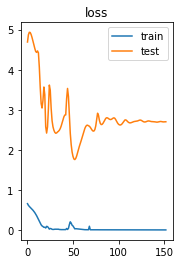

pred : -0.2506052851676941, true : -1.8937129974365234

predicted : -0.4357120990753174

춘천, 참외

[Epoch: 10] train loss :  0.76 | test loss :  0.74
[Epoch: 20] train loss :  0.53 | test loss :  1.56
[Epoch: 30] train loss :  0.21 | test loss :  0.54
[Epoch: 40] train loss :  0.02 | test loss :  0.27


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.01 | test loss :  0.07
[Epoch: 60] train loss :  0.00 | test loss :  0.09
[Epoch: 70] train loss :  0.00 | test loss :  0.07
[Epoch: 80] train loss :  0.00 | test loss :  0.08
[Epoch: 90] train loss :  0.00 | test loss :  0.09
[Epoch: 100] train loss :  0.00 | test loss :  0.09
[Epoch: 110] train loss :  0.00 | test loss :  0.09
[Epoch: 120] train loss :  0.00 | test loss :  0.09
[Epoch: 130] train loss :  0.00 | test loss :  0.09
[Epoch: 140] train loss :  0.00 | test loss :  0.09

Early Stopping
Epoch : 148


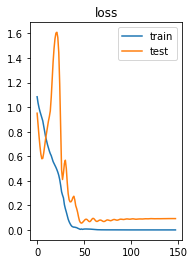

pred : 0.3863224685192108, true : 0.6899769306182861

predicted : 0.7163877487182617

춘천, 오이

[Epoch: 10] train loss :  0.49 | test loss :  0.55
[Epoch: 20] train loss :  0.05 | test loss :  0.01
[Epoch: 30] train loss :  0.03 | test loss :  0.01
[Epoch: 40] train loss :  0.02 | test loss :  0.01


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.01 | test loss :  0.00
[Epoch: 60] train loss :  0.01 | test loss :  0.00
[Epoch: 70] train loss :  0.01 | test loss :  0.00
[Epoch: 80] train loss :  0.01 | test loss :  0.00
[Epoch: 90] train loss :  0.01 | test loss :  0.00
[Epoch: 100] train loss :  0.01 | test loss :  0.00
[Epoch: 110] train loss :  0.00 | test loss :  0.00
[Epoch: 120] train loss :  0.00 | test loss :  0.00
[Epoch: 130] train loss :  0.00 | test loss :  0.00
[Epoch: 140] train loss :  0.00 | test loss :  0.00
[Epoch: 150] train loss :  0.00 | test loss :  0.00
[Epoch: 160] train loss :  0.00 | test loss :  0.01
[Epoch: 170] train loss :  0.00 | test loss :  0.01
[Epoch: 180] train loss :  0.00 | test loss :  0.01

Early Stopping
Epoch : 185


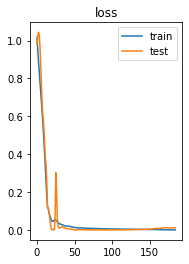

pred : -1.1237637996673584, true : -1.016420602798462

predicted : -0.18992355465888977

춘천, 호박

[Epoch: 10] train loss :  0.29 | test loss :  2.12
[Epoch: 20] train loss :  0.06 | test loss :  7.31
[Epoch: 30] train loss :  0.02 | test loss :  6.07
[Epoch: 40] train loss :  0.00 | test loss :  3.18


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.00 | test loss :  2.43
[Epoch: 60] train loss :  0.00 | test loss :  1.83
[Epoch: 70] train loss :  0.00 | test loss :  2.00
[Epoch: 80] train loss :  0.00 | test loss :  2.20
[Epoch: 90] train loss :  0.00 | test loss :  2.17
[Epoch: 100] train loss :  0.00 | test loss :  2.22
[Epoch: 110] train loss :  0.00 | test loss :  2.16

Early Stopping
Epoch : 116


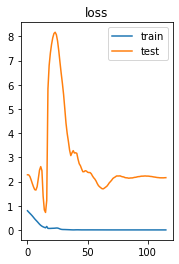

pred : -0.003421202301979065, true : -1.473039150238037

predicted : -0.9864216446876526

춘천, 배추

[Epoch: 10] train loss :  0.63 | test loss :  1.09
[Epoch: 20] train loss :  0.18 | test loss :  0.17
[Epoch: 30] train loss :  0.02 | test loss :  0.03
[Epoch: 40] train loss :  0.01 | test loss :  0.03


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.00 | test loss :  0.01
[Epoch: 60] train loss :  0.00 | test loss :  0.00
[Epoch: 70] train loss :  0.00 | test loss :  0.01
[Epoch: 80] train loss :  0.00 | test loss :  0.01
[Epoch: 90] train loss :  0.00 | test loss :  0.01
[Epoch: 100] train loss :  0.00 | test loss :  0.01
[Epoch: 110] train loss :  0.00 | test loss :  0.01
[Epoch: 120] train loss :  0.00 | test loss :  0.01

Early Stopping
Epoch : 126


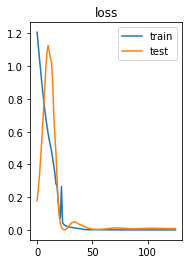

pred : 0.7713104486465454, true : 0.6777260303497314

predicted : -0.9486612677574158

춘천, 시금치

[Epoch: 10] train loss :  0.67 | test loss :  1.93
[Epoch: 20] train loss :  0.45 | test loss :  1.76
[Epoch: 30] train loss :  0.10 | test loss :  5.39
[Epoch: 40] train loss :  0.49 | test loss :  5.01


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.38 | test loss :  4.06
[Epoch: 60] train loss :  0.14 | test loss :  3.84
[Epoch: 70] train loss :  0.09 | test loss :  5.10
[Epoch: 80] train loss :  0.06 | test loss :  5.23
[Epoch: 90] train loss :  0.05 | test loss :  4.82
[Epoch: 100] train loss :  0.04 | test loss :  4.84
[Epoch: 110] train loss :  0.03 | test loss :  4.98

Early Stopping
Epoch : 116


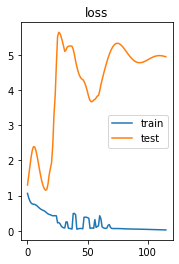

pred : 0.782866358757019, true : -1.4408718347549438

predicted : 0.6786226630210876

춘천, 상추

[Epoch: 10] train loss :  0.36 | test loss :  1.06
[Epoch: 20] train loss :  0.04 | test loss :  0.08
[Epoch: 30] train loss :  0.02 | test loss :  0.16
[Epoch: 40] train loss :  0.02 | test loss :  1.01


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.01 | test loss :  0.27
[Epoch: 60] train loss :  0.01 | test loss :  0.14
[Epoch: 70] train loss :  0.01 | test loss :  0.16
[Epoch: 80] train loss :  0.00 | test loss :  0.13
[Epoch: 90] train loss :  0.00 | test loss :  0.11
[Epoch: 100] train loss :  0.00 | test loss :  0.11
[Epoch: 110] train loss :  0.00 | test loss :  0.11

Early Stopping
Epoch : 119


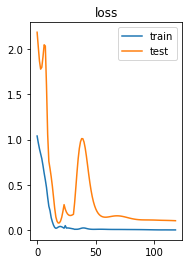

pred : -0.6512923240661621, true : -0.9706512093544006

predicted : -0.8560519814491272

춘천, 무

[Epoch: 10] train loss :  0.69 | test loss :  0.00
[Epoch: 20] train loss :  0.05 | test loss :  2.18
[Epoch: 30] train loss :  0.01 | test loss :  1.37
[Epoch: 40] train loss :  0.01 | test loss :  1.05


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.00 | test loss :  0.80
[Epoch: 60] train loss :  0.00 | test loss :  0.69
[Epoch: 70] train loss :  0.00 | test loss :  0.66
[Epoch: 80] train loss :  0.00 | test loss :  0.66
[Epoch: 90] train loss :  0.00 | test loss :  0.65
[Epoch: 100] train loss :  0.00 | test loss :  0.64

Early Stopping
Epoch : 105


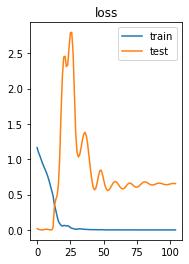

pred : 0.5885878801345825, true : -0.22044695913791656

predicted : -0.07181745022535324

춘천, 고추

[Epoch: 10] train loss :  0.40 | test loss :  1.86
[Epoch: 20] train loss :  0.04 | test loss :  0.02
[Epoch: 30] train loss :  0.00 | test loss :  0.23
[Epoch: 40] train loss :  0.00 | test loss :  0.35


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.00 | test loss :  0.25
[Epoch: 60] train loss :  0.00 | test loss :  0.31
[Epoch: 70] train loss :  0.00 | test loss :  0.32
[Epoch: 80] train loss :  0.00 | test loss :  0.30
[Epoch: 90] train loss :  0.00 | test loss :  0.31
[Epoch: 100] train loss :  0.00 | test loss :  0.31
[Epoch: 110] train loss :  0.00 | test loss :  0.31
[Epoch: 120] train loss :  0.00 | test loss :  0.31

Early Stopping
Epoch : 120


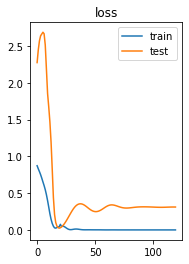

pred : 0.7202721834182739, true : 1.278147578239441

predicted : 0.887934684753418

춘천, 파

[Epoch: 10] train loss :  0.50 | test loss :  2.38
[Epoch: 20] train loss :  0.27 | test loss :  2.23
[Epoch: 30] train loss :  0.11 | test loss :  2.07
[Epoch: 40] train loss :  0.03 | test loss :  2.16


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.00 | test loss :  2.22
[Epoch: 60] train loss :  0.00 | test loss :  2.32
[Epoch: 70] train loss :  0.00 | test loss :  2.31
[Epoch: 80] train loss :  0.00 | test loss :  2.32
[Epoch: 90] train loss :  0.00 | test loss :  2.35
[Epoch: 100] train loss :  0.00 | test loss :  2.36
[Epoch: 110] train loss :  0.00 | test loss :  2.36
[Epoch: 120] train loss :  0.00 | test loss :  2.37

Early Stopping
Epoch : 127


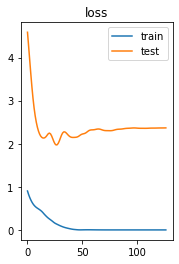

pred : -0.12292027473449707, true : -1.6616311073303223

predicted : -0.2851153016090393

춘천, 마늘

[Epoch: 10] train loss :  0.64 | test loss :  2.28
[Epoch: 20] train loss :  0.05 | test loss :  0.97
[Epoch: 30] train loss :  0.04 | test loss :  0.67
[Epoch: 40] train loss :  0.00 | test loss :  0.38


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.00 | test loss :  0.37
[Epoch: 60] train loss :  0.00 | test loss :  1.24
[Epoch: 70] train loss :  0.00 | test loss :  1.24
[Epoch: 80] train loss :  0.00 | test loss :  1.07
[Epoch: 90] train loss :  0.00 | test loss :  1.21
[Epoch: 100] train loss :  0.00 | test loss :  1.31
[Epoch: 110] train loss :  0.00 | test loss :  1.31
[Epoch: 120] train loss :  0.00 | test loss :  1.28
[Epoch: 130] train loss :  0.00 | test loss :  1.29
[Epoch: 140] train loss :  0.00 | test loss :  1.29

Early Stopping
Epoch : 147


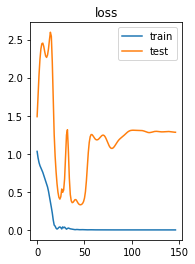

pred : -0.23430979251861572, true : -1.366866946220398

predicted : -0.9237011671066284

안동, 미곡

[Epoch: 10] train loss :  0.81 | test loss :  0.47
[Epoch: 20] train loss :  0.32 | test loss :  0.09
[Epoch: 30] train loss :  0.24 | test loss :  2.67
[Epoch: 40] train loss :  0.17 | test loss :  2.09


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.09 | test loss :  0.58
[Epoch: 60] train loss :  0.02 | test loss :  0.59
[Epoch: 70] train loss :  0.00 | test loss :  0.56
[Epoch: 80] train loss :  0.00 | test loss :  0.50
[Epoch: 90] train loss :  0.00 | test loss :  0.50
[Epoch: 100] train loss :  0.00 | test loss :  0.49
[Epoch: 110] train loss :  0.00 | test loss :  0.48
[Epoch: 120] train loss :  0.00 | test loss :  0.47

Early Stopping
Epoch : 120


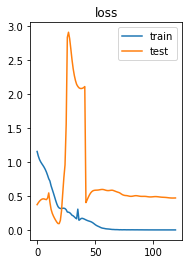

pred : 0.14219191670417786, true : -0.5441513657569885

predicted : -0.05631977319717407

안동, 맥류

[Epoch: 10] train loss :  0.67 | test loss :  0.45
[Epoch: 20] train loss :  0.36 | test loss :  0.30
[Epoch: 30] train loss :  0.08 | test loss :  0.00
[Epoch: 40] train loss :  0.01 | test loss :  0.00


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.02 | test loss :  0.14
[Epoch: 60] train loss :  0.01 | test loss :  0.10
[Epoch: 70] train loss :  0.02 | test loss :  0.09
[Epoch: 80] train loss :  0.01 | test loss :  0.00
[Epoch: 90] train loss :  0.00 | test loss :  0.00
[Epoch: 100] train loss :  0.00 | test loss :  0.02
[Epoch: 110] train loss :  0.00 | test loss :  0.03
[Epoch: 120] train loss :  0.00 | test loss :  0.02
[Epoch: 130] train loss :  0.00 | test loss :  0.03
[Epoch: 140] train loss :  0.00 | test loss :  0.03
[Epoch: 150] train loss :  0.00 | test loss :  0.03
[Epoch: 160] train loss :  0.00 | test loss :  0.03
[Epoch: 170] train loss :  0.00 | test loss :  0.03
[Epoch: 180] train loss :  0.00 | test loss :  0.03

Early Stopping
Epoch : 185


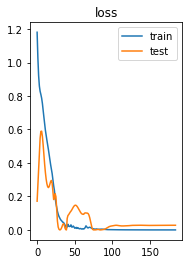

pred : -0.8541498780250549, true : -0.6872525215148926

predicted : -0.0443321168422699

안동, 잡곡

[Epoch: 10] train loss :  0.50 | test loss :  1.04
[Epoch: 20] train loss :  0.13 | test loss :  0.16
[Epoch: 30] train loss :  0.03 | test loss :  0.18
[Epoch: 40] train loss :  0.01 | test loss :  0.22


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.01 | test loss :  0.17
[Epoch: 60] train loss :  0.00 | test loss :  0.17
[Epoch: 70] train loss :  0.00 | test loss :  0.20
[Epoch: 80] train loss :  0.00 | test loss :  0.19
[Epoch: 90] train loss :  0.00 | test loss :  0.19
[Epoch: 100] train loss :  0.00 | test loss :  0.20
[Epoch: 110] train loss :  0.00 | test loss :  0.19
[Epoch: 120] train loss :  0.00 | test loss :  0.20

Early Stopping
Epoch : 123


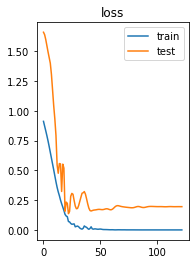

pred : 0.8535422682762146, true : 1.2952364683151245

predicted : 1.0434422492980957

안동, 두류

[Epoch: 10] train loss :  0.52 | test loss :  4.73
[Epoch: 20] train loss :  0.21 | test loss :  4.32
[Epoch: 30] train loss :  0.10 | test loss :  7.41
[Epoch: 40] train loss :  0.05 | test loss :  6.38


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.03 | test loss :  4.39
[Epoch: 60] train loss :  0.02 | test loss :  2.86
[Epoch: 70] train loss :  0.02 | test loss :  2.98
[Epoch: 80] train loss :  0.02 | test loss :  2.77
[Epoch: 90] train loss :  0.01 | test loss :  2.87
[Epoch: 100] train loss :  0.01 | test loss :  3.02
[Epoch: 110] train loss :  0.00 | test loss :  2.99
[Epoch: 120] train loss :  0.00 | test loss :  2.98
[Epoch: 130] train loss :  0.00 | test loss :  2.99
[Epoch: 140] train loss :  0.00 | test loss :  2.97
[Epoch: 150] train loss :  0.00 | test loss :  2.96
[Epoch: 160] train loss :  0.00 | test loss :  2.96
[Epoch: 170] train loss :  0.00 | test loss :  2.97
[Epoch: 180] train loss :  0.00 | test loss :  2.97

Early Stopping
Epoch : 181


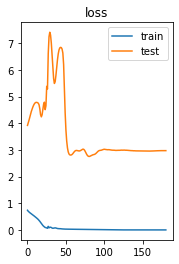

pred : -0.061498016119003296, true : -1.7858878374099731

predicted : -0.30013376474380493

안동, 서류

[Epoch: 10] train loss :  0.55 | test loss :  3.46
[Epoch: 20] train loss :  0.40 | test loss :  5.81
[Epoch: 30] train loss :  0.33 | test loss :  3.33
[Epoch: 40] train loss :  0.22 | test loss :  3.58


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.08 | test loss :  3.76
[Epoch: 60] train loss :  0.03 | test loss :  3.95
[Epoch: 70] train loss :  0.00 | test loss :  4.44
[Epoch: 80] train loss :  0.00 | test loss :  4.28
[Epoch: 90] train loss :  0.00 | test loss :  4.43
[Epoch: 100] train loss :  0.00 | test loss :  4.35
[Epoch: 110] train loss :  0.00 | test loss :  4.41
[Epoch: 120] train loss :  0.00 | test loss :  4.39
[Epoch: 130] train loss :  0.00 | test loss :  4.41

Early Stopping
Epoch : 133


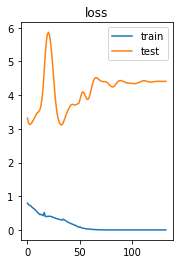

pred : 0.559384822845459, true : -1.5407167673110962

predicted : 0.2829735279083252

안동, 참외

[Epoch: 10] train loss :  0.68 | test loss :  1.14
[Epoch: 20] train loss :  0.37 | test loss :  1.53
[Epoch: 30] train loss :  0.29 | test loss :  1.49
[Epoch: 40] train loss :  0.14 | test loss :  1.30


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.07 | test loss :  0.90
[Epoch: 60] train loss :  0.02 | test loss :  0.78
[Epoch: 70] train loss :  0.01 | test loss :  0.93
[Epoch: 80] train loss :  0.00 | test loss :  0.83
[Epoch: 90] train loss :  0.00 | test loss :  0.78
[Epoch: 100] train loss :  0.00 | test loss :  0.74

Early Stopping
Epoch : 101


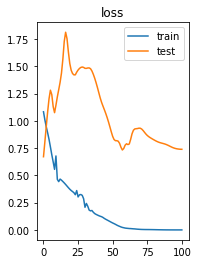

pred : -0.14641891419887543, true : -1.0059748888015747

predicted : -0.2892531752586365

안동, 오이

[Epoch: 10] train loss :  0.90 | test loss :  0.11
[Epoch: 20] train loss :  0.54 | test loss :  0.56
[Epoch: 30] train loss :  0.14 | test loss :  2.11
[Epoch: 40] train loss :  0.02 | test loss :  1.86


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.01 | test loss :  1.45
[Epoch: 60] train loss :  0.00 | test loss :  1.44
[Epoch: 70] train loss :  0.00 | test loss :  1.46
[Epoch: 80] train loss :  0.00 | test loss :  1.55
[Epoch: 90] train loss :  0.00 | test loss :  1.55
[Epoch: 100] train loss :  0.00 | test loss :  1.56

Early Stopping
Epoch : 105


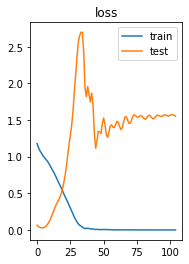

pred : 1.28415846824646, true : 0.03809092938899994

predicted : 0.6512525081634521

안동, 호박

[Epoch: 10] train loss :  0.56 | test loss :  4.02
[Epoch: 20] train loss :  0.37 | test loss :  4.98
[Epoch: 30] train loss :  0.18 | test loss :  3.81
[Epoch: 40] train loss :  0.05 | test loss :  2.77


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.01 | test loss :  2.67
[Epoch: 60] train loss :  0.00 | test loss :  2.72
[Epoch: 70] train loss :  0.00 | test loss :  2.68
[Epoch: 80] train loss :  0.00 | test loss :  2.87
[Epoch: 90] train loss :  0.00 | test loss :  2.80
[Epoch: 100] train loss :  0.00 | test loss :  2.74
[Epoch: 110] train loss :  0.00 | test loss :  2.74
[Epoch: 120] train loss :  0.00 | test loss :  2.75
[Epoch: 130] train loss :  0.00 | test loss :  2.75
[Epoch: 140] train loss :  0.00 | test loss :  2.75

Early Stopping
Epoch : 147


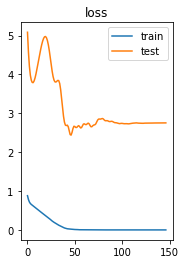

pred : 0.13461023569107056, true : 1.7942262887954712

predicted : 0.499711811542511

안동, 배추

[Epoch: 10] train loss :  0.77 | test loss :  2.13
[Epoch: 20] train loss :  0.29 | test loss :  3.74
[Epoch: 30] train loss :  0.20 | test loss :  4.11
[Epoch: 40] train loss :  0.04 | test loss :  4.25


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.02 | test loss :  4.75
[Epoch: 60] train loss :  0.01 | test loss :  4.13
[Epoch: 70] train loss :  0.01 | test loss :  4.43
[Epoch: 80] train loss :  0.00 | test loss :  4.18
[Epoch: 90] train loss :  0.00 | test loss :  4.17
[Epoch: 100] train loss :  0.00 | test loss :  4.22

Early Stopping
Epoch : 101


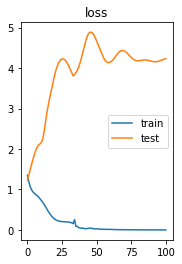

pred : -0.9500300884246826, true : 1.10662043094635

predicted : -0.790851891040802

안동, 시금치

[Epoch: 10] train loss :  0.73 | test loss :  0.22
[Epoch: 20] train loss :  0.49 | test loss :  0.00
[Epoch: 30] train loss :  0.17 | test loss :  0.04
[Epoch: 40] train loss :  0.11 | test loss :  0.04


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.07 | test loss :  0.06
[Epoch: 60] train loss :  0.03 | test loss :  0.13
[Epoch: 70] train loss :  0.00 | test loss :  0.24
[Epoch: 80] train loss :  0.00 | test loss :  0.20
[Epoch: 90] train loss :  0.00 | test loss :  0.27
[Epoch: 100] train loss :  0.00 | test loss :  0.26
[Epoch: 110] train loss :  0.00 | test loss :  0.25
[Epoch: 120] train loss :  0.00 | test loss :  0.24

Early Stopping
Epoch : 121


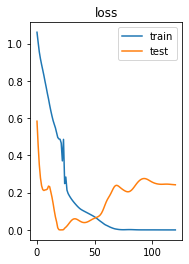

pred : -1.1468745470046997, true : -0.6545992493629456

predicted : -0.9647091627120972

안동, 상추

[Epoch: 10] train loss :  0.70 | test loss :  1.40
[Epoch: 20] train loss :  0.54 | test loss :  1.42
[Epoch: 30] train loss :  0.09 | test loss :  0.81
[Epoch: 40] train loss :  0.05 | test loss :  0.87


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.02 | test loss :  0.72
[Epoch: 60] train loss :  0.01 | test loss :  0.59
[Epoch: 70] train loss :  0.00 | test loss :  0.64
[Epoch: 80] train loss :  0.00 | test loss :  0.61
[Epoch: 90] train loss :  0.00 | test loss :  0.61
[Epoch: 100] train loss :  0.00 | test loss :  0.64
[Epoch: 110] train loss :  0.00 | test loss :  0.64
[Epoch: 120] train loss :  0.00 | test loss :  0.64
[Epoch: 130] train loss :  0.00 | test loss :  0.65
[Epoch: 140] train loss :  0.00 | test loss :  0.65
[Epoch: 150] train loss :  0.00 | test loss :  0.65

Early Stopping
Epoch : 158


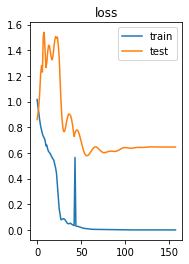

pred : -0.04147922992706299, true : -0.8452926278114319

predicted : -0.3521333336830139

안동, 무

[Epoch: 10] train loss :  0.37 | test loss :  1.02
[Epoch: 20] train loss :  0.04 | test loss :  1.57
[Epoch: 30] train loss :  0.03 | test loss :  1.66
[Epoch: 40] train loss :  0.01 | test loss :  1.50


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.01 | test loss :  1.70
[Epoch: 60] train loss :  0.01 | test loss :  1.74
[Epoch: 70] train loss :  0.00 | test loss :  1.66
[Epoch: 80] train loss :  0.00 | test loss :  1.54
[Epoch: 90] train loss :  0.00 | test loss :  1.54
[Epoch: 100] train loss :  0.00 | test loss :  1.53
[Epoch: 110] train loss :  0.00 | test loss :  1.51
[Epoch: 120] train loss :  0.00 | test loss :  1.48

Early Stopping
Epoch : 126


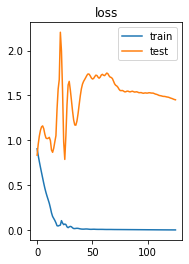

pred : 0.4674069285392761, true : -0.7374013662338257

predicted : -0.9381837248802185

안동, 고추

[Epoch: 10] train loss :  0.62 | test loss :  0.15
[Epoch: 20] train loss :  0.32 | test loss :  0.16
[Epoch: 30] train loss :  0.15 | test loss :  0.37
[Epoch: 40] train loss :  0.05 | test loss :  0.55


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.04 | test loss :  0.55
[Epoch: 60] train loss :  0.01 | test loss :  0.66
[Epoch: 70] train loss :  0.00 | test loss :  0.58
[Epoch: 80] train loss :  0.00 | test loss :  0.52
[Epoch: 90] train loss :  0.00 | test loss :  0.60
[Epoch: 100] train loss :  0.00 | test loss :  0.56
[Epoch: 110] train loss :  0.00 | test loss :  0.57

Early Stopping
Epoch : 114


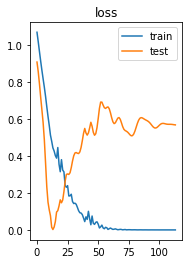

pred : -1.5943739414215088, true : -0.8399292230606079

predicted : -1.2360634803771973

안동, 파

[Epoch: 10] train loss :  0.46 | test loss :  0.05
[Epoch: 20] train loss :  0.11 | test loss :  0.05
[Epoch: 30] train loss :  0.01 | test loss :  0.01
[Epoch: 40] train loss :  0.01 | test loss :  0.01


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.01 | test loss :  0.00
[Epoch: 60] train loss :  0.00 | test loss :  0.00
[Epoch: 70] train loss :  0.00 | test loss :  0.00
[Epoch: 80] train loss :  0.00 | test loss :  0.00
[Epoch: 90] train loss :  0.00 | test loss :  0.00
[Epoch: 100] train loss :  0.00 | test loss :  0.00
[Epoch: 110] train loss :  0.00 | test loss :  0.00
[Epoch: 120] train loss :  0.00 | test loss :  0.00
[Epoch: 130] train loss :  0.00 | test loss :  0.00
[Epoch: 140] train loss :  0.00 | test loss :  0.00
[Epoch: 150] train loss :  0.00 | test loss :  0.00
[Epoch: 160] train loss :  0.00 | test loss :  0.00
[Epoch: 170] train loss :  0.00 | test loss :  0.00
[Epoch: 180] train loss :  0.00 | test loss :  0.00
[Epoch: 190] train loss :  0.00 | test loss :  0.00
[Epoch: 200] train loss :  0.00 | test loss :  0.00
[Epoch: 210] train loss :  0.00 | test loss :  0.00
[Epoch: 220] train loss :  0.00 | test loss :  0.00
[Epoch: 230] train loss :  0.00 | test loss :  0.00
[Epoch: 240] trai

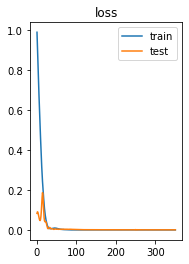

pred : -0.3895905315876007, true : -0.41064831614494324

predicted : -0.600186288356781

안동, 마늘

[Epoch: 10] train loss :  0.70 | test loss :  0.01
[Epoch: 20] train loss :  0.29 | test loss :  0.12
[Epoch: 30] train loss :  0.06 | test loss :  0.09
[Epoch: 40] train loss :  0.01 | test loss :  0.07


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.00 | test loss :  0.09
[Epoch: 60] train loss :  0.00 | test loss :  0.06
[Epoch: 70] train loss :  0.00 | test loss :  0.07
[Epoch: 80] train loss :  0.00 | test loss :  0.07
[Epoch: 90] train loss :  0.00 | test loss :  0.06
[Epoch: 100] train loss :  0.00 | test loss :  0.07

Early Stopping
Epoch : 101


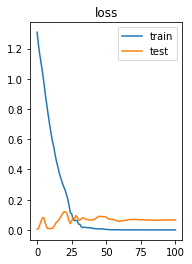

pred : -0.01657325029373169, true : 0.24037648737430573

predicted : 0.29912132024765015

제주, 미곡

[Epoch: 10] train loss :  0.34 | test loss :  2.19
[Epoch: 20] train loss :  0.20 | test loss :  0.42
[Epoch: 30] train loss :  0.15 | test loss :  0.66
[Epoch: 40] train loss :  0.12 | test loss :  0.85


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.11 | test loss :  0.84
[Epoch: 60] train loss :  0.08 | test loss :  0.91
[Epoch: 70] train loss :  0.05 | test loss :  1.24
[Epoch: 80] train loss :  0.02 | test loss :  1.50
[Epoch: 90] train loss :  0.00 | test loss :  1.72
[Epoch: 100] train loss :  0.00 | test loss :  2.13
[Epoch: 110] train loss :  0.00 | test loss :  2.23
[Epoch: 120] train loss :  0.00 | test loss :  2.25

Early Stopping
Epoch : 120


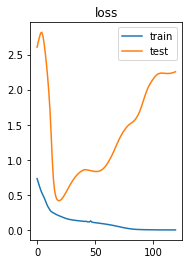

pred : -0.23195548355579376, true : -1.7333003282546997

predicted : -0.8164849877357483

제주, 맥류

[Epoch: 10] train loss :  0.88 | test loss :  0.45
[Epoch: 20] train loss :  0.53 | test loss :  0.96
[Epoch: 30] train loss :  0.32 | test loss :  1.47
[Epoch: 40] train loss :  0.11 | test loss :  1.73


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.02 | test loss :  1.57
[Epoch: 60] train loss :  0.01 | test loss :  1.51
[Epoch: 70] train loss :  0.00 | test loss :  1.98
[Epoch: 80] train loss :  0.00 | test loss :  2.30
[Epoch: 90] train loss :  0.00 | test loss :  2.28
[Epoch: 100] train loss :  0.00 | test loss :  2.19

Early Stopping
Epoch : 101


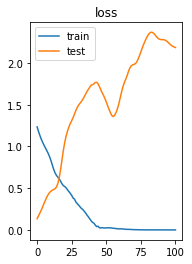

pred : 0.790990948677063, true : -0.6875600218772888

predicted : 0.5777754187583923

제주, 잡곡

[Epoch: 10] train loss :  0.34 | test loss :  0.85
[Epoch: 20] train loss :  0.22 | test loss :  0.09
[Epoch: 30] train loss :  0.11 | test loss :  0.02
[Epoch: 40] train loss :  0.13 | test loss :  0.02


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.05 | test loss :  0.22
[Epoch: 60] train loss :  0.04 | test loss :  0.21
[Epoch: 70] train loss :  0.02 | test loss :  0.33
[Epoch: 80] train loss :  0.01 | test loss :  0.50
[Epoch: 90] train loss :  0.01 | test loss :  0.52
[Epoch: 100] train loss :  0.01 | test loss :  0.47
[Epoch: 110] train loss :  0.00 | test loss :  0.43
[Epoch: 120] train loss :  0.00 | test loss :  0.37
[Epoch: 130] train loss :  0.00 | test loss :  0.34

Early Stopping
Epoch : 133


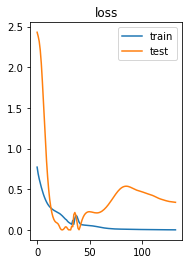

pred : 1.8961181640625, true : 1.3136610984802246

predicted : 0.440383642911911

제주, 두류

[Epoch: 10] train loss :  0.42 | test loss :  0.90
[Epoch: 20] train loss :  0.15 | test loss :  0.11
[Epoch: 30] train loss :  0.05 | test loss :  0.00
[Epoch: 40] train loss :  0.03 | test loss :  0.01


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.01 | test loss :  0.01
[Epoch: 60] train loss :  0.00 | test loss :  0.03
[Epoch: 70] train loss :  0.00 | test loss :  0.05
[Epoch: 80] train loss :  0.00 | test loss :  0.05
[Epoch: 90] train loss :  0.00 | test loss :  0.04
[Epoch: 100] train loss :  0.00 | test loss :  0.04
[Epoch: 110] train loss :  0.00 | test loss :  0.04
[Epoch: 120] train loss :  0.00 | test loss :  0.04
[Epoch: 130] train loss :  0.00 | test loss :  0.04

Early Stopping
Epoch : 133


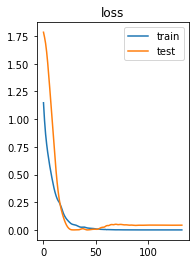

pred : -1.4508882761001587, true : -1.244062900543213

predicted : -1.1738203763961792

제주, 서류

[Epoch: 10] train loss :  0.92 | test loss :  0.96
[Epoch: 20] train loss :  0.66 | test loss :  1.08
[Epoch: 30] train loss :  0.35 | test loss :  0.87
[Epoch: 40] train loss :  0.11 | test loss :  0.84


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.00 | test loss :  1.16
[Epoch: 60] train loss :  0.00 | test loss :  1.19
[Epoch: 70] train loss :  0.00 | test loss :  1.16
[Epoch: 80] train loss :  0.00 | test loss :  1.22
[Epoch: 90] train loss :  0.00 | test loss :  1.17
[Epoch: 100] train loss :  0.00 | test loss :  1.20

Early Stopping
Epoch : 101


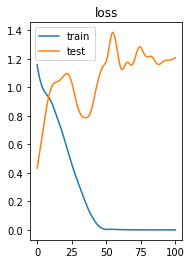

pred : -0.3605569005012512, true : 0.7389882206916809

predicted : -0.053884245455265045

제주, 참외

[Epoch: 10] train loss :  0.52 | test loss :  0.77
[Epoch: 20] train loss :  0.26 | test loss :  0.43
[Epoch: 30] train loss :  0.08 | test loss :  0.26


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 40] train loss :  0.02 | test loss :  0.16
[Epoch: 50] train loss :  0.00 | test loss :  0.04
[Epoch: 60] train loss :  0.00 | test loss :  0.01
[Epoch: 70] train loss :  0.00 | test loss :  0.02
[Epoch: 80] train loss :  0.00 | test loss :  0.03
[Epoch: 90] train loss :  0.00 | test loss :  0.03
[Epoch: 100] train loss :  0.00 | test loss :  0.03
[Epoch: 110] train loss :  0.00 | test loss :  0.03
[Epoch: 120] train loss :  0.00 | test loss :  0.03
[Epoch: 130] train loss :  0.00 | test loss :  0.03
[Epoch: 140] train loss :  0.00 | test loss :  0.03
[Epoch: 150] train loss :  0.00 | test loss :  0.03
[Epoch: 160] train loss :  0.00 | test loss :  0.03

Early Stopping
Epoch : 162


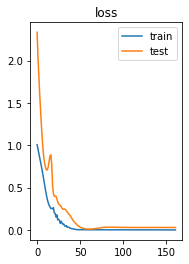

pred : -0.9454540014266968, true : -1.114524006843567

predicted : -1.2059122323989868

제주, 오이

[Epoch: 10] train loss :  0.41 | test loss :  5.65
[Epoch: 20] train loss :  0.20 | test loss :  5.15
[Epoch: 30] train loss :  0.10 | test loss :  4.88
[Epoch: 40] train loss :  0.04 | test loss :  3.23


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.03 | test loss :  2.65
[Epoch: 60] train loss :  0.01 | test loss :  2.80
[Epoch: 70] train loss :  0.00 | test loss :  2.91
[Epoch: 80] train loss :  0.00 | test loss :  2.88
[Epoch: 90] train loss :  0.00 | test loss :  2.91
[Epoch: 100] train loss :  0.00 | test loss :  2.91
[Epoch: 110] train loss :  0.00 | test loss :  2.90
[Epoch: 120] train loss :  0.00 | test loss :  2.91
[Epoch: 130] train loss :  0.00 | test loss :  2.92
[Epoch: 140] train loss :  0.00 | test loss :  2.91
[Epoch: 150] train loss :  0.00 | test loss :  2.91

Early Stopping
Epoch : 151


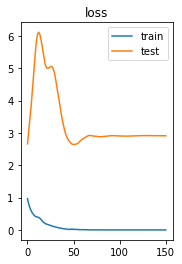

pred : -0.3460763096809387, true : -2.052280902862549

predicted : -0.46020129323005676

제주, 호박

[Epoch: 10] train loss :  0.70 | test loss :  0.00
[Epoch: 20] train loss :  0.37 | test loss :  0.03
[Epoch: 30] train loss :  0.16 | test loss :  0.02
[Epoch: 40] train loss :  0.20 | test loss :  2.12


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.15 | test loss :  2.99
[Epoch: 60] train loss :  0.11 | test loss :  3.02
[Epoch: 70] train loss :  0.07 | test loss :  3.12
[Epoch: 80] train loss :  0.05 | test loss :  3.40
[Epoch: 90] train loss :  0.03 | test loss :  3.49
[Epoch: 100] train loss :  0.01 | test loss :  3.46
[Epoch: 110] train loss :  0.01 | test loss :  3.69
[Epoch: 120] train loss :  0.00 | test loss :  3.88

Early Stopping
Epoch : 125


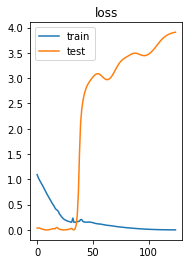

pred : -2.120509147644043, true : -0.14394745230674744

predicted : -1.4455558061599731

제주, 배추

[Epoch: 10] train loss :  0.37 | test loss :  0.00
[Epoch: 20] train loss :  0.26 | test loss :  0.00
[Epoch: 30] train loss :  0.18 | test loss :  0.00
[Epoch: 40] train loss :  0.04 | test loss :  0.00


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.01 | test loss :  0.00
[Epoch: 60] train loss :  0.01 | test loss :  0.01
[Epoch: 70] train loss :  0.00 | test loss :  0.01
[Epoch: 80] train loss :  0.00 | test loss :  0.01
[Epoch: 90] train loss :  0.00 | test loss :  0.02
[Epoch: 100] train loss :  0.00 | test loss :  0.02
[Epoch: 110] train loss :  0.00 | test loss :  0.02
[Epoch: 120] train loss :  0.00 | test loss :  0.02
[Epoch: 130] train loss :  0.00 | test loss :  0.02
[Epoch: 140] train loss :  0.00 | test loss :  0.02
[Epoch: 150] train loss :  0.00 | test loss :  0.02

Early Stopping
Epoch : 155


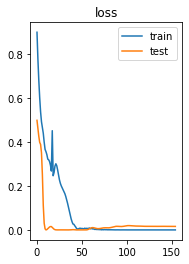

pred : -1.0475564002990723, true : -0.92148756980896

predicted : -0.4185781180858612

제주, 시금치

[Epoch: 10] train loss :  0.53 | test loss :  2.90
[Epoch: 20] train loss :  0.18 | test loss :  3.36
[Epoch: 30] train loss :  0.04 | test loss :  3.32
[Epoch: 40] train loss :  0.00 | test loss :  3.48


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.00 | test loss :  3.47
[Epoch: 60] train loss :  0.00 | test loss :  3.35
[Epoch: 70] train loss :  0.00 | test loss :  3.37
[Epoch: 80] train loss :  0.00 | test loss :  3.37
[Epoch: 90] train loss :  0.00 | test loss :  3.32
[Epoch: 100] train loss :  0.00 | test loss :  3.32

Early Stopping
Epoch : 101


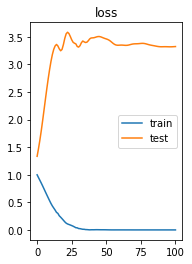

pred : 0.7002697587013245, true : -1.1225963830947876

predicted : 0.3357113003730774

제주, 상추

[Epoch: 10] train loss :  0.85 | test loss :  0.41
[Epoch: 20] train loss :  0.57 | test loss :  1.02
[Epoch: 30] train loss :  0.24 | test loss :  1.03
[Epoch: 40] train loss :  0.03 | test loss :  0.96


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.01 | test loss :  0.73
[Epoch: 60] train loss :  0.00 | test loss :  0.71
[Epoch: 70] train loss :  0.00 | test loss :  0.65
[Epoch: 80] train loss :  0.00 | test loss :  0.61
[Epoch: 90] train loss :  0.00 | test loss :  0.57
[Epoch: 100] train loss :  0.00 | test loss :  0.54

Early Stopping
Epoch : 104


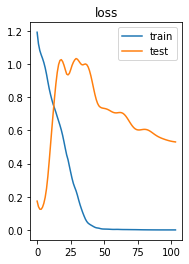

pred : -0.54600989818573, true : 0.18254415690898895

predicted : -0.3343134820461273

제주, 무

[Epoch: 10] train loss :  0.92 | test loss :  0.27
[Epoch: 20] train loss :  0.43 | test loss :  1.07
[Epoch: 30] train loss :  0.11 | test loss :  1.83
[Epoch: 40] train loss :  0.02 | test loss :  0.94


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.01 | test loss :  0.13
[Epoch: 60] train loss :  0.01 | test loss :  0.14
[Epoch: 70] train loss :  0.06 | test loss :  0.18
[Epoch: 80] train loss :  0.03 | test loss :  0.37
[Epoch: 90] train loss :  0.02 | test loss :  0.32
[Epoch: 100] train loss :  0.01 | test loss :  0.63
[Epoch: 110] train loss :  0.00 | test loss :  0.40
[Epoch: 120] train loss :  0.00 | test loss :  0.45
[Epoch: 130] train loss :  0.00 | test loss :  0.53
[Epoch: 140] train loss :  0.00 | test loss :  0.50
[Epoch: 150] train loss :  0.00 | test loss :  0.51

Early Stopping
Epoch : 151


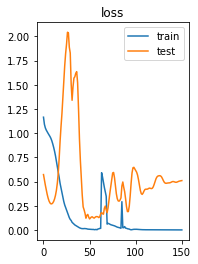

pred : -0.27886587381362915, true : 0.43498945236206055

predicted : 0.09937983751296997

제주, 고추

[Epoch: 10] train loss :  0.62 | test loss :  0.09
[Epoch: 20] train loss :  0.08 | test loss :  0.39
[Epoch: 30] train loss :  0.03 | test loss :  0.28
[Epoch: 40] train loss :  0.01 | test loss :  0.17


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.00 | test loss :  0.16
[Epoch: 60] train loss :  0.00 | test loss :  0.21
[Epoch: 70] train loss :  0.00 | test loss :  0.24
[Epoch: 80] train loss :  0.00 | test loss :  0.23
[Epoch: 90] train loss :  0.00 | test loss :  0.22
[Epoch: 100] train loss :  0.00 | test loss :  0.21

Early Stopping
Epoch : 105


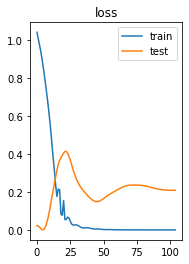

pred : -0.7848818898200989, true : -0.32780537009239197

predicted : -0.6405888199806213

제주, 파

[Epoch: 10] train loss :  0.78 | test loss :  0.88
[Epoch: 20] train loss :  0.57 | test loss :  0.25
[Epoch: 30] train loss :  0.24 | test loss :  0.08
[Epoch: 40] train loss :  0.05 | test loss :  0.00


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.04 | test loss :  0.03
[Epoch: 60] train loss :  0.01 | test loss :  0.11
[Epoch: 70] train loss :  0.01 | test loss :  0.17
[Epoch: 80] train loss :  0.01 | test loss :  0.16
[Epoch: 90] train loss :  0.00 | test loss :  0.14
[Epoch: 100] train loss :  0.00 | test loss :  0.13
[Epoch: 110] train loss :  0.00 | test loss :  0.15
[Epoch: 120] train loss :  0.00 | test loss :  0.16
[Epoch: 130] train loss :  0.00 | test loss :  0.16
[Epoch: 140] train loss :  0.00 | test loss :  0.16

Early Stopping
Epoch : 143


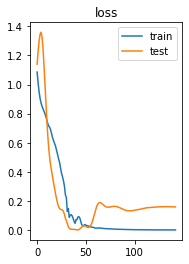

pred : 1.4567095041275024, true : 1.05872642993927

predicted : 1.2361533641815186

제주, 마늘

[Epoch: 10] train loss :  0.59 | test loss :  1.58
[Epoch: 20] train loss :  0.30 | test loss :  2.00
[Epoch: 30] train loss :  0.10 | test loss :  2.15
[Epoch: 40] train loss :  0.01 | test loss :  2.27


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch: 50] train loss :  0.00 | test loss :  1.86
[Epoch: 60] train loss :  0.00 | test loss :  1.77
[Epoch: 70] train loss :  0.00 | test loss :  1.91
[Epoch: 80] train loss :  0.00 | test loss :  1.91
[Epoch: 90] train loss :  0.00 | test loss :  1.95
[Epoch: 100] train loss :  0.00 | test loss :  1.92

Early Stopping
Epoch : 101


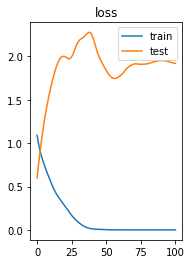

pred : -0.9315271377563477, true : 0.45376476645469666

predicted : -0.7636053562164307


In [25]:
pred_list = []
for i in range(3) :
    pred_list_Grain = []
    pred_list_Fruit = []
    for j in range(5):
        model = Crop_LSTM(input_dim, seq_len, n_layers, hidden_dim, output_dim, device).to(device)
        criterion = nn.MSELoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        print(f"\n{pos_list[i]}, {feature1[j]}\n")
        trained_model = train_and_eval2(model, dataloader_list[i][0][j][0], dataloader_list[i][0][j][1], 
                                       num_epochs, criterion, optimizer, early_stop_patience)
        criterion = nn.MSELoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        trained_model = train_again2(trained_model, criterion, optimizer, dataloader_list[i][0][j][1])
        pred_x_list = []
        for k, (x, y) in enumerate(dataloader_list[i][0][j][1]) :
            pred_x_list.append(x)
        logit = trained_model(torch.FloatTensor(x).to(device)) #
        predicted = torch.flatten(logit)
        print(f"\npredicted : {predicted.item()}")
        pred_list_Grain.append(predicted.item())
    for j in range(10):
        model = Crop_LSTM(input_dim, seq_len, n_layers, hidden_dim, output_dim, device).to(device)
        criterion = nn.MSELoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        print(f"\n{pos_list[i]}, {feature2[j]}\n")
        trained_model = train_and_eval2(model, dataloader_list[i][1][j][0], dataloader_list[i][1][j][1], 
                                       num_epochs, criterion, optimizer, early_stop_patience)
        criterion = nn.MSELoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        trained_model = train_again2(trained_model, criterion, optimizer, dataloader_list[i][1][j][1])
        pred_x_list = []
        for k, (x, y) in enumerate(dataloader_list[i][1][j][1]) :
            pred_x_list.append(x)
        logit = trained_model(torch.FloatTensor(x).to(device)) #
        predicted = torch.flatten(logit)
        print(f"\npredicted : {predicted.item()}")
        pred_list_Fruit.append(predicted.item())
    pred_list.append((pred_list_Grain, pred_list_Fruit))

곡물 생산량 예측 표 출력

In [27]:
Grain_list = []
for i in range(3) :
  Grain_list.append(pred_list[i][0])
Grain_table = pd.DataFrame(np.array(Grain_list), columns=feature1, index=["춘천", "안동", "제주"])
Grain_table

,미곡,맥류,잡곡,두류,서류
춘천,0.490952,-0.593341,0.284762,-0.076022,-0.435712
안동,-0.056320,-0.044332,1.043442,-0.300134,0.282974
제주,-0.816485,0.577775,0.440384,-1.173820,-0.053884


각 지역에서 가장 생산량이 많을 것으로 추정되는 작물을 추천

In [28]:
Grain_table.idxmax(axis=1)

춘천    미곡
안동    잡곡
제주    맥류
dtype: object

과채류 생산량 예측 표 출력

In [29]:
Fruit_list = []
for i in range(3) :
  Fruit_list.append(pred_list[i][1])
Fruit_table = pd.DataFrame(np.array(Fruit_list), columns=feature2, index=["춘천", "안동", "제주"])
Fruit_table

,참외,오이,호박,배추,시금치,상추,무,고추,파,마늘
춘천,0.716388,-0.189924,-0.986422,-0.948661,0.678623,-0.856052,-0.071817,0.887935,-0.285115,-0.923701
안동,-0.289253,0.651253,0.499712,-0.790852,-0.964709,-0.352133,-0.938184,-1.236063,-0.600186,0.299121
제주,-1.205912,-0.460201,-1.445556,-0.418578,0.335711,-0.334313,0.099380,-0.640589,1.236153,-0.763605


In [30]:
Fruit_table.idxmax(axis=1)

춘천    고추
안동    오이
제주     파
dtype: object